<a href="https://colab.research.google.com/github/GallardoCarmen/Mineria_Datos/blob/main/Lab04_Grupo02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://www.ufv.es/wp-content/uploads/2023/03/logo-UFV-scaled.jpg" alt="Logo de Colab" width="200">

# <font color='00008B'>GRUPO 02.</font>
##### Carmen Gallardo Martín, David Marín Sala, Laura Lirón Carrión y Nuria Prol Vecoña.

# <font color='00008B'>LABORATORIO 4.</font>

In [53]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.base import clone
from sklearn.utils import resample
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from sklearn.decomposition import PCA

from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage

**FALTA DESRIPCIÓN DE LA BASE DE DATOS**

Para comenzar, cargamos la base de datos en la que los datos están separados por punto y coma (`;`). Utilizamos el comando `.head()` para mostrar el contenido de las primeras cinco filas y verificar que se hayan cargado correctamente.

In [ ]:
datos = 'wine_alcohol.csv'
datos = pd.read_csv(datos, delimiter=';')

#Ejercicio 1 (Regresión lineal simple)


Una prestigiosa empresa productora de vinos quiere construir un modelo de regresión que le permita predecir el porcentaje de alcohol de un vino en base a ciertas características (acidez, azúcar residual, azufre, cloruros, densidad, tipo de vino, sulfatos y pH).
Para ello han construido un dataset, denominado wine_alcohol.csv, que contiene la información de todos los vinos que han sido producidos en los últimos años con el objetivo de construir un modelo y realizar las siguientes acciones:

1)Realizar todo el proceso de preparación, limpieza y análisis de los datos con el objetivo de identificar
aquellas variables candidatas para el proceso de regresión (0.5 puntos).

2) Realizar un análisis sobre los atributos del dataset con el objetivo de entender las posibles relaciones
que existen entre ellas y a continuación elige los dos atributos que mayor relación guardan con el
atributo objetivo (nivel de alcohol) (1 punto). En necesario justificar la elección de los atributos
mediante la utilización de datos empíricos.

3) Construir un modelo de regresión lineal mediante un proceso analítico para una de las variables
seleccionadas en el punto anterior (1 punto).

4) Calcular el error en el modelo obtenidos en el punto anterior (0.5 puntos).

-----

**1) Realizar todo el proceso de preparación, limpieza y análisis de los datos con el objetivo de identificar aquellas variables candidatas para el proceso de regresión**



Una vez cargados los datos, procedemos con la preparación y limpieza de los mismos. Primero, eliminamos cualquier dato faltante para asegurar la integridad del análisis. Posteriormente, descartamos la variable 'Id', ya que no aporta información relevante para nuestro estudio.

In [ ]:
#Eliminamos los datos faltantes
valores_nan = datos.isnull().sum()
print(valores_nan)

#ID no tendrá información significativa para la regresión
datos.drop('id', axis=1, inplace=True)

id                      0
fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
quality                 0
wine type               0
alcohol                 0
dtype: int64


No se detectaron valores faltantes en el conjunto de datos, por lo que no se requiere eliminar ningún registro en este momento.

A continuación, procedemos a analizar la distribución de las variables utilizando gráficos de caja y bigotes. Este tipo de gráfico nos permite visualizar los outliers que presenta cada variable y facilita la toma de decisiones basada en la dispersión y la distribución de los datos.

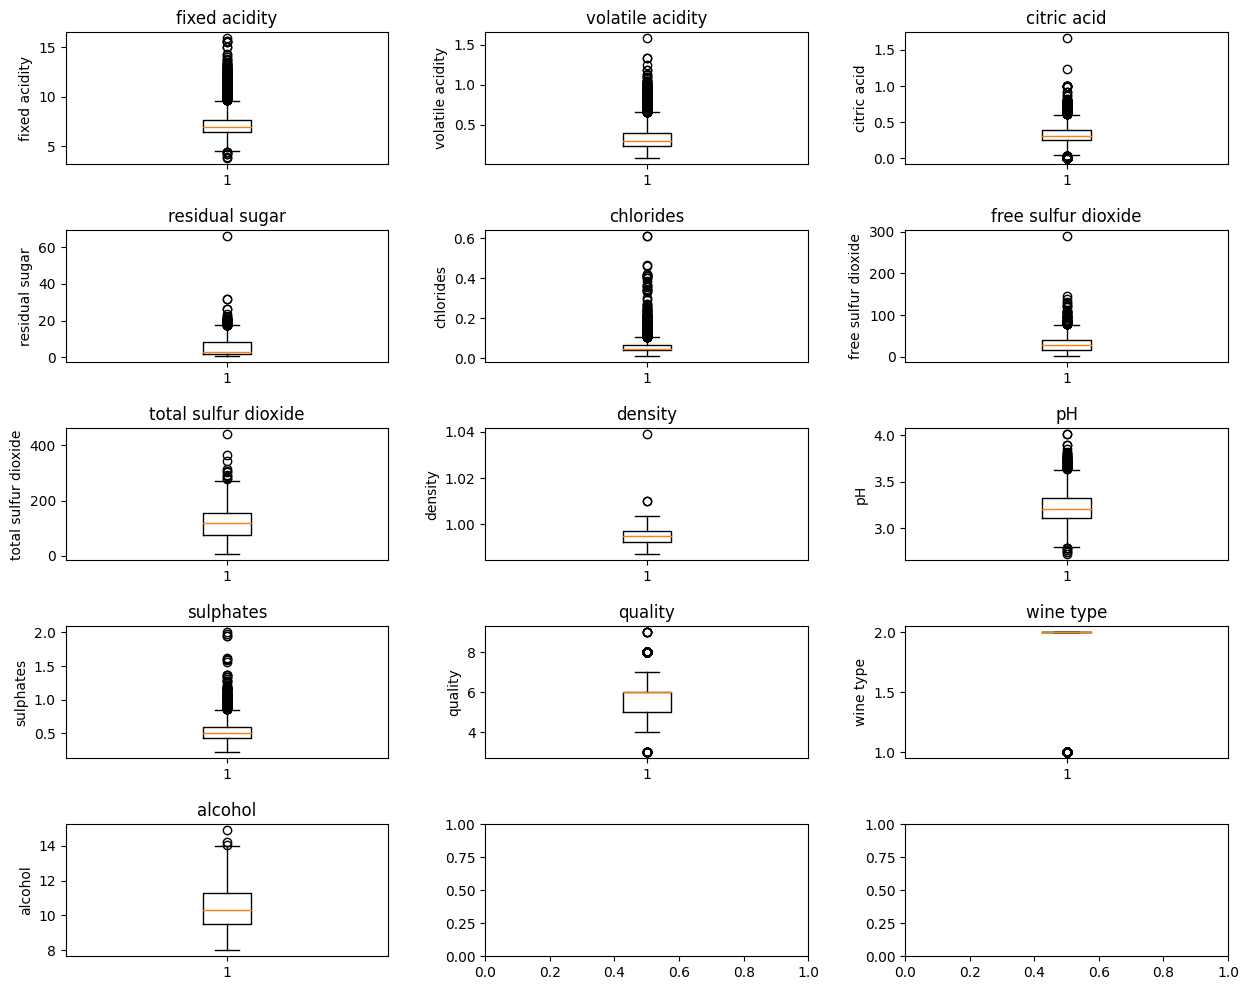

Variable             IQR             Outliers
----------------------------------------
fixed acidity        1.30            357
volatile acidity     0.17            377
citric acid          0.14            509
residual sugar       6.30            118
chlorides            0.03            286
free sulfur dioxide  24.00           62
total sulfur dioxide 79.00           10
density              0.00            3
pH                   0.21            73
sulphates            0.17            191
quality              1.00            228
wine type            0.00            1599
alcohol              1.80            3


In [ ]:
variables = datos.columns

fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(15, 12))
fig.subplots_adjust(hspace=0.5, wspace=0.3) #Espacio entre graficass

outlier_data = []

for i, var in enumerate(variables):
    ax = axes[i // 3, i % 3]
    ax.boxplot(datos[var].dropna())
    ax.set_title(var)
    ax.set_ylabel(var)

    # Cálculo de cuartiles y valores atípicos
    Q1 = datos[var].quantile(0.25)
    Q3 = datos[var].quantile(0.75)
    IQR = Q3 - Q1
    outliers = datos[(datos[var] < (Q1 - 1.5 * IQR)) | (datos[var] > (Q3 + 1.5 * IQR))]
    outlier_count = len(outliers)

    outlier_data.append((var, f"{IQR:.2f}", outlier_count))

plt.show()

# Mostrar información sobre valores atípicos
print(f"{'Variable':<20} {'IQR':<15} {'Outliers'}")
print('-' * 40)
for var, iqr, count in outlier_data:
    print(f"{var:<20} {iqr:<15} {count}")


Al examinar los outliers en cada variable a través de los gráficos de caja y bigotes, se observa que algunos pueden ser especialmente significativos para el análisis. Por ejemplo, en la variable `density`, solo se identifican 3 outliers. Estos puntos están considerablemente alejados de la "caja" principal de la distribución, lo que sugiere que podrían ser errores de medición o casos atípicos extremos. Dado su escaso número y distancia significativa, se eliminarán para no distorsionar la regresión.

Por otro lado, la variable `Wine Type` presenta una gran cantidad de outliers, con 1599 puntos atípicos. La extensa cantidad de estos sugiere que podrían representar un patrón importante o una característica distintiva del conjunto de datos, más que simples anomalías. Esta observación nos lleva a decidir conservar estos outliers para un análisis posterior, ya que podrían ofrecer insights valiosos sobre particularidades específicas asociadas al tipo de vino.

In [ ]:
#Calculamso el rango intercuartilico de density
Q1_density = datos['density'].quantile(0.25)
Q3_density = datos['density'].quantile(0.75)
IQR_density = Q3_density - Q1_density

#Outliers
lower_bound = Q1_density - 1.5 * IQR_density
upper_bound = Q3_density + 1.5 * IQR_density

#ELiminamos outiers
datos = datos[(datos['density'] >= lower_bound) & (datos['density'] <= upper_bound)]

Una vez realizado el análisis de outliers, procedemos a examinar la distribución de cada variable en la base de datos. Al observar estas distribuciones, podremos identificar cuáles presentan una forma similar a la de la variable "alcohol". Esta comparación es crucial para determinar qué variables son candidatas potenciales para incluir en el proceso de regresión. Esto nos ayudará a entender mejor las relaciones entre "alcohol" y otras variables, y a seleccionar aquellas que podrían ser predictores significativos en nuestro modelo de regresión.

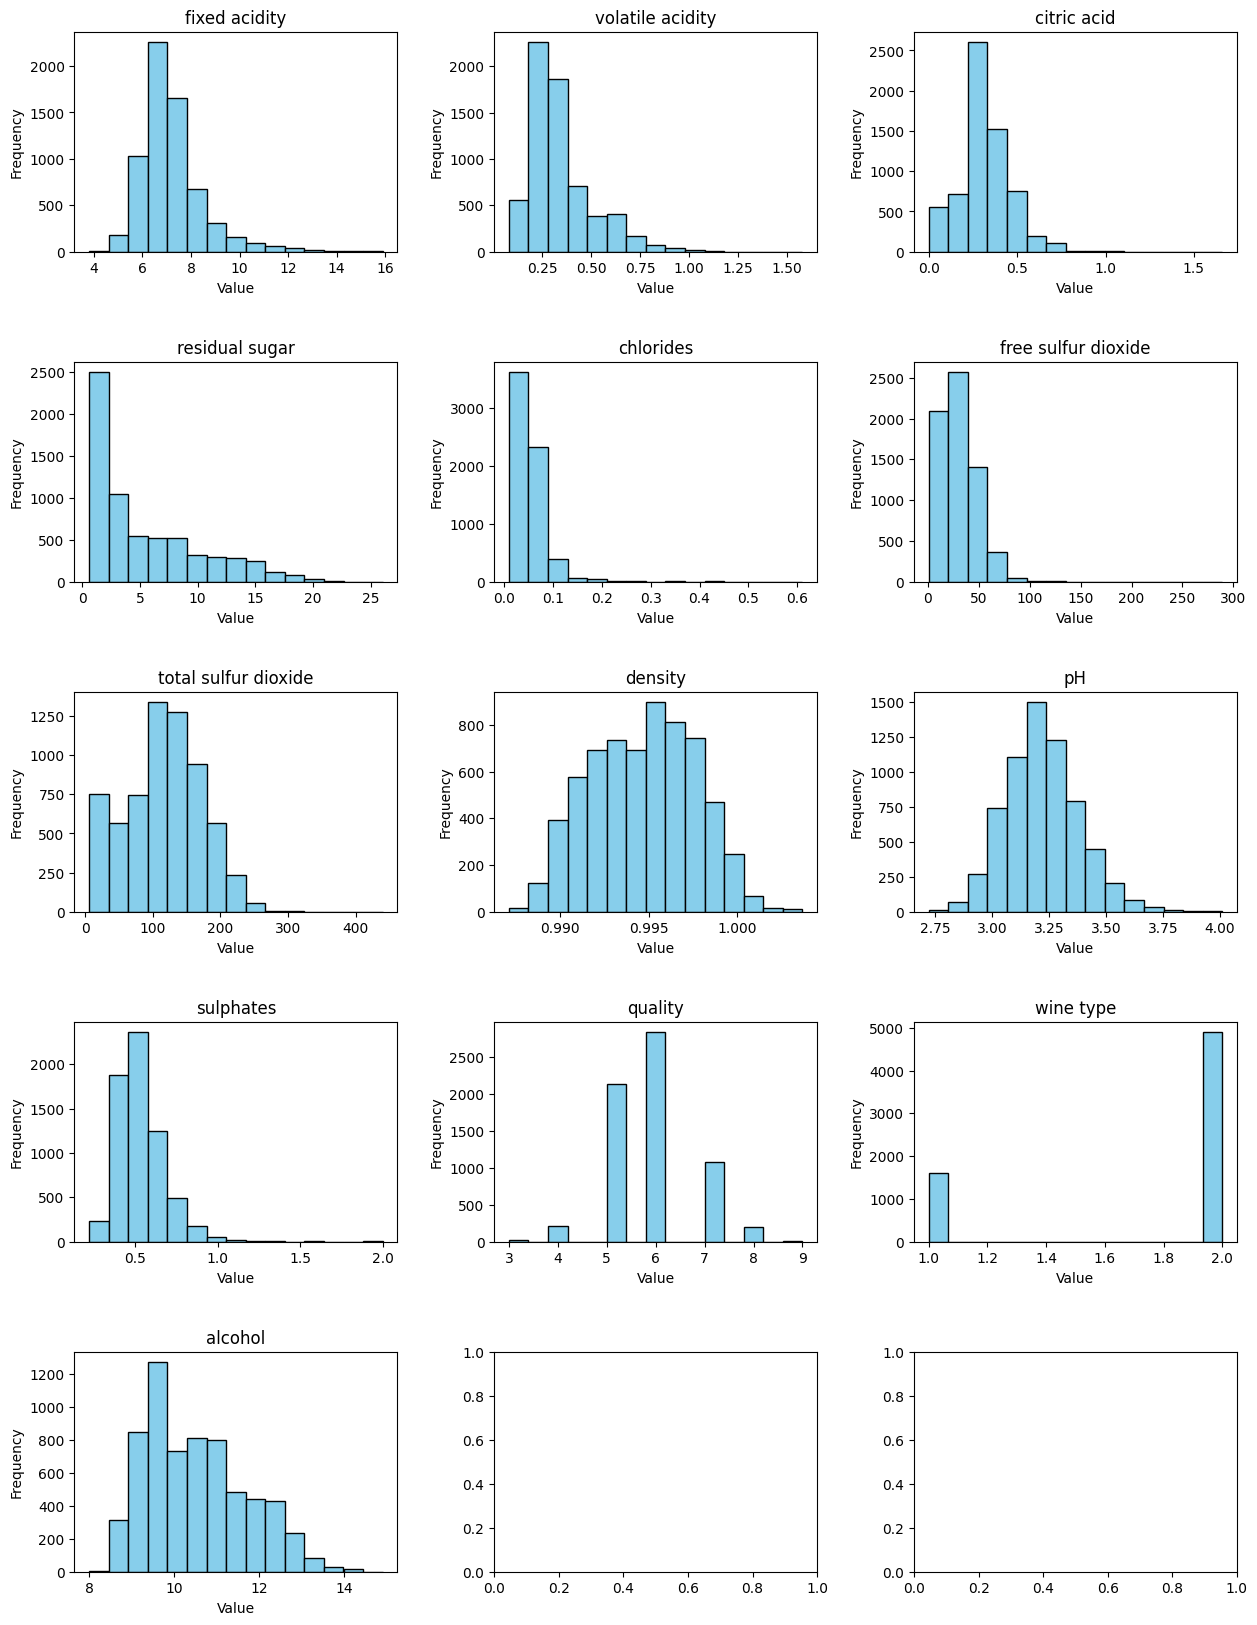

In [ ]:
# Configurando la figura y los ejes para los subplots
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(15, 20))  # Ajustado para 5 filas y 3 columnas
fig.subplots_adjust(hspace=0.5, wspace=0.3)  # Ajustando el espacio entre gráficos

for i, var in enumerate(variables):
    ax = axes[i // 3, i % 3]  # Determina en qué posición del grid colocar cada subplot
    # Creando un histograma para cada variable
    ax.hist(datos[var].dropna(), bins=15, color='skyblue', edgecolor='black')
    ax.set_title(var)
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')

plt.show()


Las variables con la distribución más similar a alcohol son:


*   Density
*   pH
*   Total sufur dioxide


Para definir si son útiles para la regresión debemos analizar su correlación con la variable objetivo.


**2) Realizar un análisis sobre los atributos del dataset con el objetivo de entender las posibles relaciones que existen entre ellas y a continuación elige los dos atributos que mayor relación guardan con el atributo objetivo (nivel de alcohol) (1 punto).
En necesario justificar la elección de los atributos mediante la utilización de datos empíricos.**

Construimos una matriz de correlación para identificar qué variables muestran una mayor relación con la variable objetivo. Aquellas que exhiban las correlaciones más fuertes, tanto positivas como negativas, serán las más indicadas para incluir en un modelo de regresión lineal.

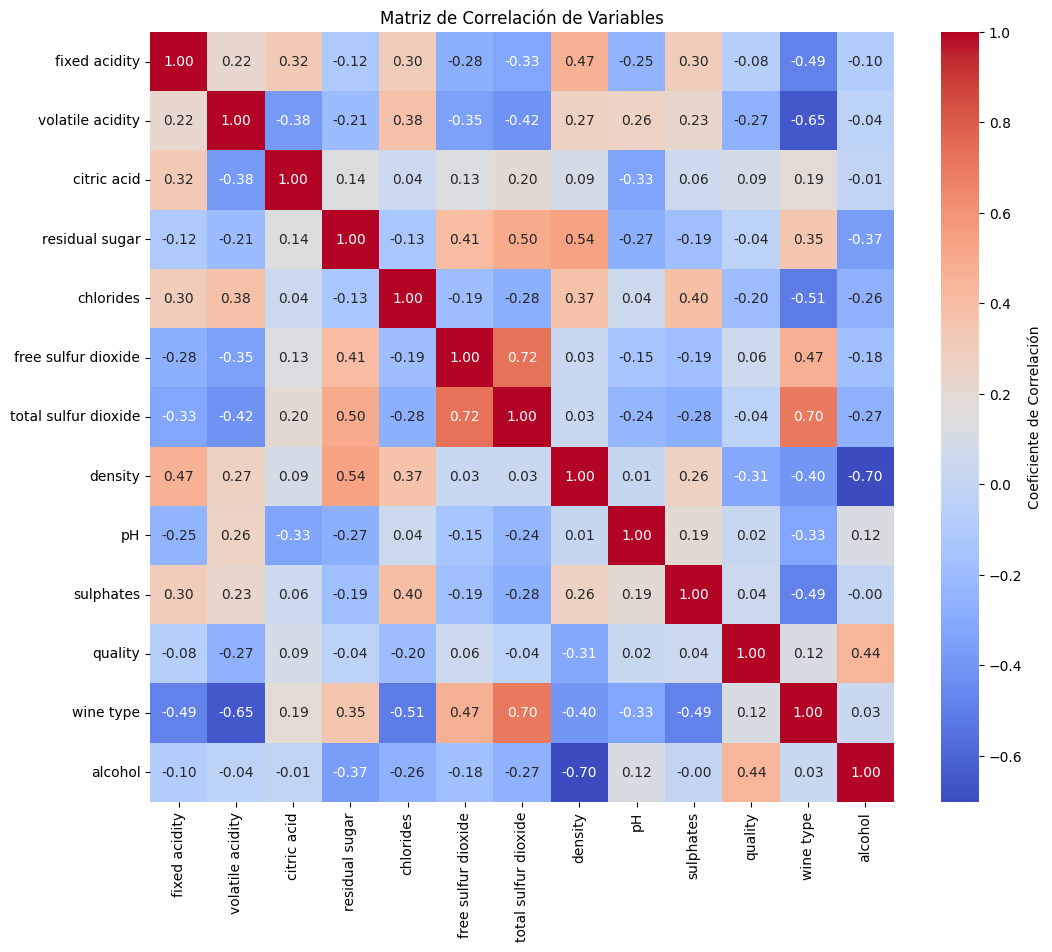

alcohol                 1.000000
density                -0.701913
quality                 0.444554
residual sugar         -0.365414
total sulfur dioxide   -0.265558
chlorides              -0.257139
free sulfur dioxide    -0.179624
pH                      0.120957
fixed acidity          -0.095334
volatile acidity       -0.038316
wine type               0.033145
citric acid            -0.010919
sulphates              -0.003642
Name: alcohol, dtype: float64

In [ ]:
plt.figure(figsize=(12, 10))

corr_matrix = datos.corr()

sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar_kws={'label': 'Coeficiente de Correlación'})
plt.title("Matriz de Correlación de Variables")
plt.show()

#Correlaciones con la variable objetivo
#Orden de mayor a menor en valor absoluto
correlaciones_alcohol = corr_matrix['alcohol'].sort_values(key=lambda x: x.abs(), ascending=False)
correlaciones_alcohol


Ahora que tenmos las correlaciones entre las variables anañizamos las relaciones más fuerte con la variable Alcohol que es la variable que buscamos predecir a partir de otra. Esta otra variable debe ser la que mantenga mayor correlación con alcohol.

##Análisis de Correlaciones

1. **Density (-0.701913)**: Esta es la correlación más fuerte y negativa con el nivel de alcohol. Esto indica que a medida que el contenido de alcohol aumenta, la densidad del vino tiende a disminuir. La densidad del vino es afectada por el contenido de azúcares y alcohol, por lo que es esperado que esta variable tenga una fuerte relación inversa con el alcohol.

2. **Quality (0.444554)**: Esta también muestra una correlación moderada con el nivel de alcohol. Una correlación de 0.44 significa que, en general, a medida que el contenido de alcohol en el vino aumenta, también tiende a aumentar su calidad.

Usar estos dos atributos en un modelo de regresión para predecir el nivel de alcohol es apropiado debido a su significativa relación con el porcentaje de alcohol, como indican los coeficientes de correlación. Además, estos atributos ayudarán a proporcionar un modelo que puede interpretar de manera efectiva cómo las características del vino influyen en su contenido alcohólico.

## Gráficos de dispersión

Ahora analizaremos mediante un gráfico de dispersión la relación directa entre ambas variables con la variable objetivo.

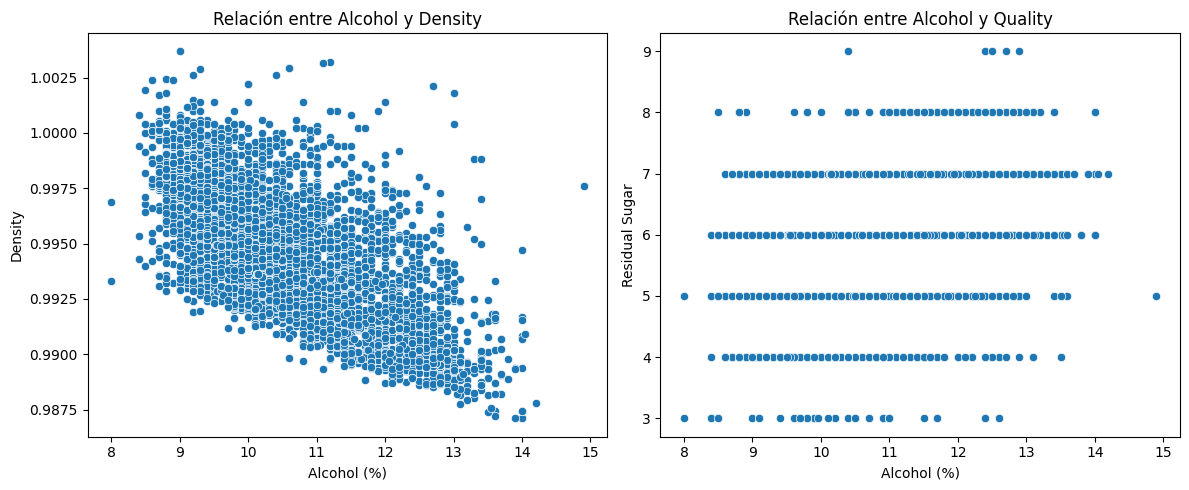

In [ ]:
plt.figure(figsize=(12, 5))

# Gráfico para 'density' vs 'alcohol'
plt.subplot(1, 2, 1)
sns.scatterplot(x=datos['alcohol'], y=datos['density'])
plt.title('Relación entre Alcohol y Density')
plt.xlabel('Alcohol (%)')
plt.ylabel('Density')

# Gráfico para 'quality' vs 'alcohol'
plt.subplot(1, 2, 2)
sns.scatterplot(x=datos['alcohol'], y=datos['quality'])
plt.title('Relación entre Alcohol y Quality')
plt.xlabel('Alcohol (%)')
plt.ylabel('Residual Sugar')

plt.tight_layout()
plt.show()


###Gráfica Alcohol vs Density
En el gráfico podemos analizar la tendencia decreciente que tiene sentido porque la relación entre vaiables era negariva. Podemos ver como a medida que el nivel de alchohol aumenta, la densidad disminuye. A partir de este gráfico podemos ver que la densidad es un buen predictor ya que la relación se muestra consistente para todo el rango de valores.
Entre estas dos variables existe una correlación lineal negativa

###Gráfica Alcohol vs Quality
En este gráfico no se observa una tendencia clara o lineal, esto sugiere que, aunque hay una tendencia a que los vinos con más alcohol sean de mayor calidad, hay muchos otros factores que influyen en la calidad del vino y que el alcohol por sí solo no es un predictor definitivo.


A partir de estos dos gráficos podemos definir que el mejor predictor será la variable denisty,.


**3) Construir un modelo de regresión lineal mediante un proceso analítico para una de las variables seleccionadas en el punto anterior (1 punto).**

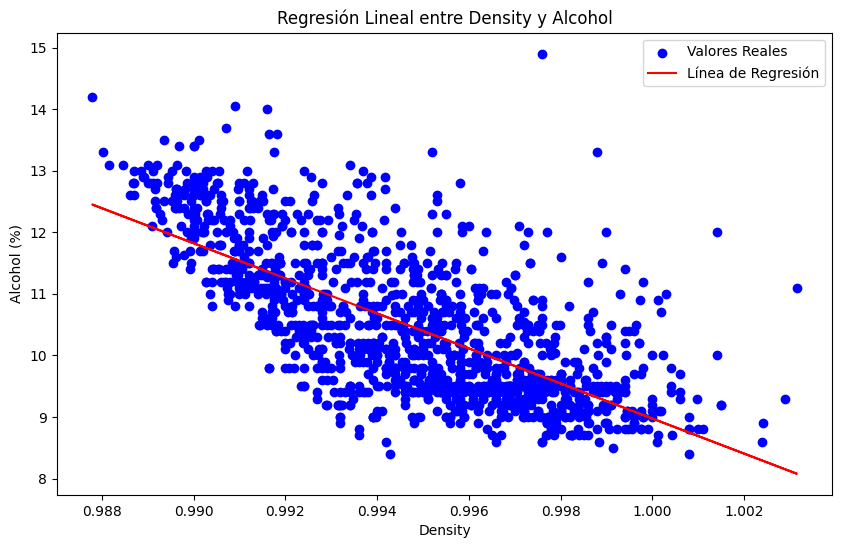

In [ ]:
X = datos[['density']]  #variable independiente
y = datos['alcohol']    #variable dependiente

# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modelo de regresión lineal
model = LinearRegression()
model.fit(X_train, y_train)

# Predicciones coon el conjunto de prueba
y_pred = model.predict(X_test)

# Graficar los resultados
plt.figure(figsize=(10, 6))
plt.scatter(X_test['density'], y_test, color='blue', label='Valores Reales')
plt.plot(X_test['density'], y_pred, color='red', label='Línea de Regresión')  # Línea de regresión
plt.title('Regresión Lineal entre Density y Alcohol')
plt.xlabel('Density')
plt.ylabel('Alcohol (%)')
plt.legend()
plt.show()

Mostramos la regresión lineal entra la variable "Density" y "Alcohol".
La pendiente de la línea de regresión es negativa, lo que sugiere que a medida que aumenta la Density, el porcentaje de Alcohol tiende a disminuir.

La alta dispersión entre las observaciones, indica que aunque hay una tendencia general, existen otros factores que también podrían estar influyendo, por lo que el modelo no se ajusta a los datos al 100%.


**4) Calcular el error en el modelo obtenidos en el punto anterior (0.5 puntos).**

Para obetener el error en el modelo, predeciremos los datos que hemos separados con el test y calcularemos el MSE.

El MSE es el promedio de los cuadrados de los errores; es decir, la diferencia cuadrática media entre los valores estimados y los reales. Se busca que este número sea lo menor posible.



In [ ]:
# Haciendo predicciones en el conjunto de prueba
y_pred = model.predict(X_test)

# Calculando el MSE
mse = mean_squared_error(y_test, y_pred)

mse

0.7431593983449122

Obtuvimos un error bajo, lo que sugiere que el error cuadrático medio entre las predicciones y los valores reales es pequeño. Esto indica que tenemos un modelo que tiene un buen ajuste a los datos.

Calcularemos también el coeficiente de determinación $R^2$ que es una medida estadística de qué tan bien las predicciones aproximadas por el modelo de regresión corresponden a los datos reales observados.

Un $R^2$ de 1 indica que el modelo de regresión predice perfectamente los valores reales. Por el contrario, un
$R^2$ de 0 sugiere que el modelo no explica la variabilidad de los datos.

In [ ]:
r2 = r2_score(y_test, y_pred)

r2

0.4895462884594667

 Un $R^2$ de 0.489 indica que el modelo puede explicar el 48.9% de la variabilidad en la variable dependiente a partir de las variables independientes. Es decir que el 48.9% de la variabilidad de la variable alcohol puede ser explicada por density. Para mejor este porcentaje será necesario incluir más variables para predecir alcohol.

Para evaluar la eficacia del modelo, graficaremos los valores reales junto a los valores predichos y observaremos cuán próximos están entre sí. Esto nos permitirá visualizar directamente la precisión de las predicciones del modelo.

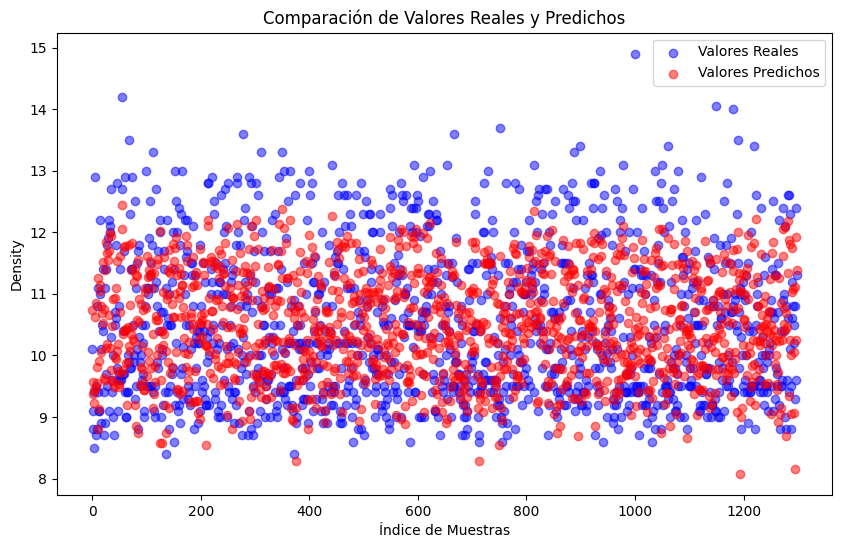

In [ ]:
plt.figure(figsize=(10, 6))

#valores reales
plt.scatter(range(len(y_test)), y_test, color='blue', label='Valores Reales', alpha=0.5)

#valores predichos
plt.scatter(range(len(y_pred)), y_pred, color='red', label='Valores Predichos', alpha=0.5)

plt.title('Comparación de Valores Reales y Predichos')
plt.xlabel('Índice de Muestras')
plt.ylabel('Density')
plt.legend()

plt.show()

Los puntos rojos (predicciones) y azules (valores reales)
varían en un rango similar, pero hay una considerable dispersión entre ellos, lo que representa que el modelo capta la tendencia general pero hay variaciones específicas en los datos que no están siendo completamente capturadas. Estas variaciones podrían ser representadas si se añadieran más variables independientes al modelo.


#Ejercicio 2 (Regresión lineal múltiple)

La empresa productora de vinos cree que es posible construir un modelo de mejor calidad que pueda predecir
mejor el grado de alcohol de los futuros vinos si se utilizan varios atributos del dataset. Para ello se solicita la
creación de nuevos modelos realizando las siguientes acciones:

1) Crear los diferentes conjuntos de entrenamiento y test para el dataset (0.25 puntos).

2) Construir un modelo de regresión que utilice al menos 4 de los atributos (es posible utilizar más
atributos) disponibles en el dataset mediante la utilización de un proceso aprendizaje iterativo. (1.5
puntos).

3) Calcular el error del modelo (0.5 puntos).

4) Evaluar el modelo anterior con el conjunto de test construido anteriormente y explicar el resultado
obtenido. (0.25 puntos).

5) Calcular los intervalos de confianza para cada uno de los coeficientes de regresión con un intervalo de
confianza del 75% y explica el resultado obtenido (0.5 puntos).

---

Teniendo en cuenta que la base de datos ya ha sido depurada y preparada para ser usada en el ejercicio anterior, vamos directamente a los ejercicios propuestos por el problema.

**1) Crear los diferentes conjuntos de entrenamiento y test para el dataset.**

Para abordar el ejercicio, el primer paso esencial consiste en preparar adecuadamente nuestros datos para el análisis y modelado posterior. Esto se logra mediante la creación de conjuntos de entrenamiento y prueba.

El objetivo de dividir el dataset en conjuntos de entrenamiento y prueba es garantizar que el modelo pueda ser entrenado con una parte sustancial de los datos (80%) y luego ser evaluado con datos no vistos, representados por el conjunto de prueba (20%). Esta estrategia ayuda a detectar problemas de sobreajuste, donde el modelo se desempeña excepcionalmente bien en los datos de entrenamiento pero falla al enfrentarse a nuevos datos.

In [ ]:
# Separamos las características (X) del OBJETIVO (y).
X = datos.drop('alcohol', axis=1)
y = datos['alcohol']

# Dividimos los datos en conjuntos de entrenamiento y prueba con una proporción del 80-20.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Verificamos las dimensiones de los conjuntos.
print("- Conjunto de entrenamiento (X_train): {} muestras, con {} características cada una.".format(X_train.shape[0], X_train.shape[1]))
print("- Conjunto de prueba (X_test): {} muestras, también con {} características.".format(X_test.shape[0], X_test.shape[1]))
print("- Valores objetivo de entrenamiento (y_train): {} valores de la variable 'alcohol'.".format(y_train.shape[0]))
print("- Valores objetivo de prueba (y_test): {} valores de la variable 'alcohol'.".format(y_test.shape[0]))

- Conjunto de entrenamiento (X_train): 5195 muestras, con 12 características cada una.
- Conjunto de prueba (X_test): 1299 muestras, también con 12 características.
- Valores objetivo de entrenamiento (y_train): 5195 valores de la variable 'alcohol'.
- Valores objetivo de prueba (y_test): 1299 valores de la variable 'alcohol'.


El resultado es un conjunto de entrenamiento que consta de 5195 muestras, cada una con 12 características, lo que proporciona una base sólida para el entrenamiento. Por otro lado, el conjunto de prueba incluye 1299 muestras, también con 12 características, lo que permite una evaluación fiable del modelo.

**2) Construir un modelo de regresión que utilice al menos 4 de los atributos disponibles en el dataset mediante la utilización de un proceso aprendizaje iterativo.**

En el segundo ejercicio de nuestro estudio, hemos desarrollado tres modelos distintos con el objetivo de optimizar y entender la predicción del grado de alcohol en los vinos basándonos en diferentes combinaciones de atributos del dataset. Esta diversificación en la selección de atributos permite evaluar la influencia de distintas características en la precisión del modelo y determinar cuáles contribuyen más significativamente a la predicción del contenido alcohólico.

**MODELOS DESARROLLADOS:**

- **Modelo con 4 variables**: Este modelo utiliza los atributos 'fixed acidity', 'volatile acidity', 'citric acid' y 'residual sugar'.

- **Modelo con 8 variables**: Ampliando la complejidad, este modelo incorpora variables adicionales como 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', y 'density'.

- **Modelo con 12 variables**: El modelo más exhaustivo incluye todas las variables anteriores más 'pH', 'sulphates', 'quality' y 'wine type'.

In [ ]:
# Creamos tres conjuntos de características con 4, 8 y 12 atributos.
X_4 = X[['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar']]
X_8 = X[['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density']]
X_12 = X[['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'quality', 'wine type']]

X_train_4, X_test_4, y_train_4, y_test_4 = train_test_split(X_4, y, test_size=0.2, random_state=42)
X_train_8, X_test_8, y_train_8, y_test_8 = train_test_split(X_8, y, test_size=0.2, random_state=42)
X_train_12, X_test_12, y_train_12, y_test_12 = train_test_split(X_12, y, test_size=0.2, random_state=42)

# Creamos el modelo de regresión con 4 atributos.
modelo_4 = make_pipeline(StandardScaler(), SGDRegressor(max_iter=1000, tol=1e-3))
modelo_4.fit(X_train_4, y_train_4)

# Creamos el modelo de regresión con 8 atributos
modelo_8 = make_pipeline(StandardScaler(), SGDRegressor(max_iter=1000, tol=1e-3))
modelo_8.fit(X_train_8, y_train_8)

# Creamos el modelo de regresión con 10 atributos
modelo_12 = make_pipeline(StandardScaler(), SGDRegressor(max_iter=1000, tol=1e-3))
modelo_12.fit(X_train_12, y_train_12)

(modelo_4, modelo_8, modelo_12)

(Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('sgdregressor', SGDRegressor())]),
 Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('sgdregressor', SGDRegressor())]),
 Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('sgdregressor', SGDRegressor())]))

Además de entrenar los modelos, podemos graficarlos graficarlos para:

- **Identificar Tendencias y Discrepancias**: Los gráficos permiten observar de manera directa cómo las predicciones de los modelos se alinean con los valores reales. Una alineación cercana entre estos dos indica un modelo de mayor precisión y fiabilidad.

- **Evaluación Visual del Ajuste del Modelo**: Mediante la representación gráfica, podemos evaluar rápidamente el ajuste del modelo a los datos. Las líneas de identidad en los gráficos, donde los valores predichos igualan a los valores reales, sirven como referencia para evaluar la precisión de las predicciones.

- **Facilitar la Interpretación y Comunicación de Resultados**: Los gráficos son intuitivos y facilitan la comprensión de los resultados para audiencias no técnicas, haciendo más accesible la discusión de los hallazgos y las implicaciones del estudio.

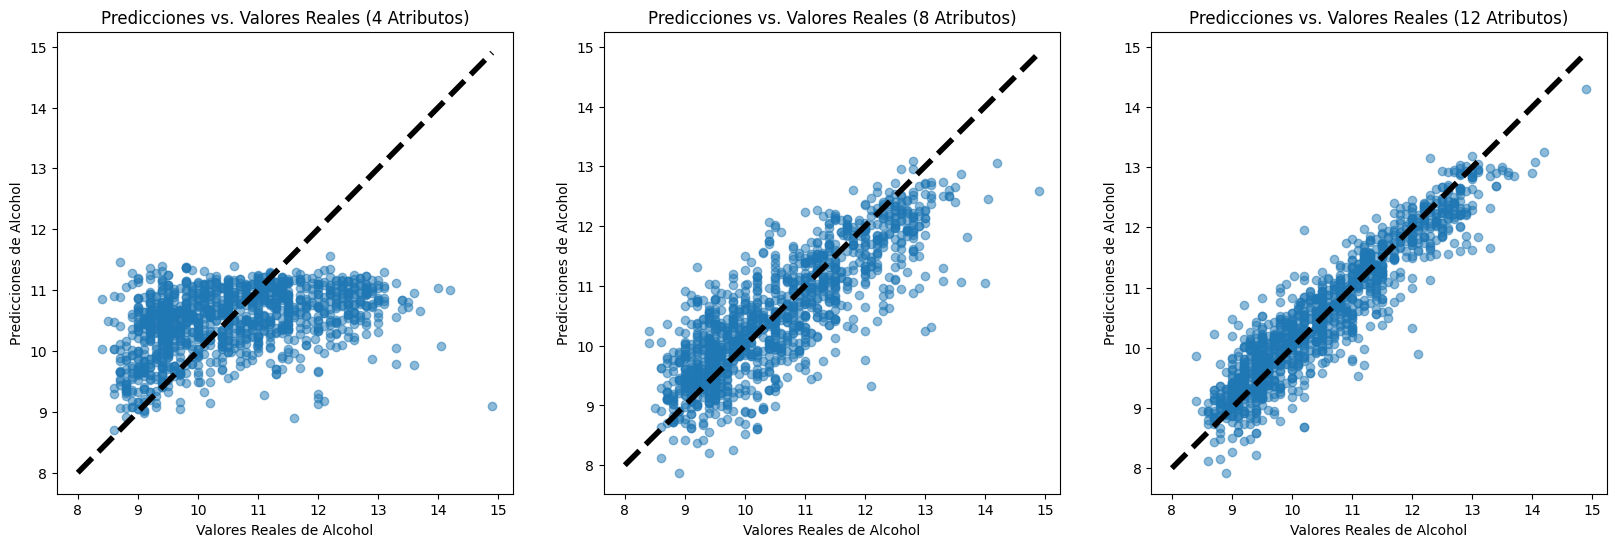

In [ ]:
# Realizamos predicciones con los modelos.
y_pred_4 = modelo_4.predict(X_test_4)
y_pred_8 = modelo_8.predict(X_test_8)
y_pred_12 = modelo_12.predict(X_test_12)

# Graficamos las predicciones vs los valores reales para cada modelo.
plt.figure(figsize=(20, 6))

# Gráfico para el modelo con 4 atributos.
plt.subplot(1, 3, 1)
plt.scatter(y_test_4, y_pred_4, alpha=0.5)
plt.title('Predicciones vs. Valores Reales (4 Atributos)')
plt.xlabel('Valores Reales de Alcohol')
plt.ylabel('Predicciones de Alcohol')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)

# Gráfico para el modelo con 8 atributos.
plt.subplot(1, 3, 2)
plt.scatter(y_test_8, y_pred_8, alpha=0.5)
plt.title('Predicciones vs. Valores Reales (8 Atributos)')
plt.xlabel('Valores Reales de Alcohol')
plt.ylabel('Predicciones de Alcohol')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)

# Gráfico para el modelo con 12 atributos.
plt.subplot(1, 3, 3)
plt.scatter(y_test_12, y_pred_12, alpha=0.5)
plt.title('Predicciones vs. Valores Reales (12 Atributos)')
plt.xlabel('Valores Reales de Alcohol')
plt.ylabel('Predicciones de Alcohol')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)

plt.show()

A través de la representación gráfica de las predicciones contra los valores reales de alcohol, como ya hemos explicado, es posible extraer conclusiones significativas sobre el desempeño y la precisión de cada modelo.

- **Modelo de 4 Atributos**: Las predicciones hechas por el modelo con cuatro variables muestran una dispersión considerable en torno a la línea de identidad. Aunque en general las predicciones siguen la tendencia de los valores reales, hay una notable variabilidad, especialmente en valores intermedios de contenido de alcohol. Esto sugiere que mientras el modelo capta la relación general, le falta precisión, posiblemente debido a la limitada cantidad de atributos considerados.

- **Modelo de 8 Atributos**: La adición de cuatro variables adicionales parece mejorar la agrupación de las predicciones cerca de la línea de identidad, indicando una mayor precisión en comparación con el modelo de 4 atributos. La mejora en la precisión es evidente en cómo las predicciones se concentran más cercanamente alrededor de la línea de identidad, reduciendo la variabilidad en los errores.

- **Modelo de 12 Atributos**: Este modelo, que incluye el conjunto más amplio de variables, muestra la alineación más cercana con la línea de identidad, lo que refleja la mayor precisión y consistencia en las predicciones. La densidad de puntos alrededor de la línea sugiere que este modelo es el más efectivo de los tres, incorporando una gama más amplia de factores que influyen en el contenido de alcohol.

**3) Calcula el error de ambos modelos.**

Para avanzar con el ejercicio, es muy importante realizar una evaluación cuantitativa del rendimiento de los modelos de regresión desarrollados. Este análisis se centra en la medición de los errores asociados a las predicciones de los modelos, utilizando el error cuadrático medio (MSE) y el error absoluto medio (MAE). Estas métricas son fundamentales para entender la efectividad de cada modelo y guiar las decisiones futuras respecto a la selección de variables y ajustes de modelado.

- **Error Cuadrático Medio (MSE)**: Esta métrica proporciona una medida del promedio de los cuadrados de los errores; es decir, la diferencia cuadrática media entre los valores estimados y los valores reales. Un MSE más bajo indica un modelo con mejor ajuste a los datos.

- **Error Absoluto Medio (MAE)**: El MAE mide el promedio de las diferencias absolutas entre las predicciones y los valores reales, proporcionando una perspectiva de la magnitud media del error sin considerar su dirección. Al igual que con el MSE, un valor menor en el MAE sugiere un modelo de predicción más preciso.

El calculo del MSE y del MAE para cada uno de los modelos construidos utilizando 4, 8 y 12 atributos, permite una comparación directa de cómo la inclusión de más variables afecta la precisión del modelo.

In [ ]:
# Calculamos el error cuadrático medio (MSE) y el error absoluto medio (MAE) para el modelo de 4 atributos.
mse_4 = mean_squared_error(y_test_4, y_pred_4)
mae_4 = mean_absolute_error(y_test_4, y_pred_4)

# Calculamos el MSE y MAE para el modelo de 8 atributos.
mse_8 = mean_squared_error(y_test_8, y_pred_8)
mae_8 = mean_absolute_error(y_test_8, y_pred_8)

# Calculamos el MSE y MAE para el modelo de 12 atributos.
mse_12 = mean_squared_error(y_test_12, y_pred_12)
mae_12 = mean_absolute_error(y_test_12, y_pred_12)

# Resultados de los errores.
print("Resultados de los errores:")
print("\n")
print("- MSE (4 Atributos): {:.4f}".format(mse_4))
print("- MAE (4 Atributos): {:.4f}".format(mae_4))
print("- MSE (8 Atributos): {:.4f}".format(mse_8))
print("- MAE (8 Atributos): {:.4f}".format(mae_8))
print("- MSE (12 Atributos): {:.4f}".format(mse_12))
print("- MAE (12 Atributos): {:.4f}".format(mae_12))
print("\n")
print("- MSE (4 Atributos): {:.2f} %".format(mse_4 * 100))
print("- MAE (4 Atributos): {:.2f} %".format(mae_4 * 100))
print("- MSE (8 Atributos): {:.2f} %".format(mse_8 * 100))
print("- MAE (8 Atributos): {:.2f} %".format(mae_8 * 100))
print("- MSE (12 Atributos): {:.2f} %".format(mse_12 * 100))
print("- MAE (12 Atributos): {:.2f} %".format(mae_12 * 100))

Resultados de los errores:


- MSE (4 Atributos): 1.2322
- MAE (4 Atributos): 0.8999
- MSE (8 Atributos): 0.4665
- MAE (8 Atributos): 0.5260
- MSE (12 Atributos): 0.1959
- MAE (12 Atributos): 0.3398


- MSE (4 Atributos): 123.22 %
- MAE (4 Atributos): 89.99 %
- MSE (8 Atributos): 46.65 %
- MAE (8 Atributos): 52.60 %
- MSE (12 Atributos): 19.59 %
- MAE (12 Atributos): 33.98 %


La evaluación cuantitativa de los errores de los modelos de regresión desarrollados para predecir el grado de alcohol en vinos, basándose en 4, 8 y 12 atributos, amplía los hallazgos observados en las visualizaciones gráficas previas.

- **Modelo de 4 Atributos**: Este modelo muestra los valores más altos tanto en MSE como en MAE, con 1.2316 y 0.8992 respectivamente. Estos valores altos indican una precisión relativamente baja y una variabilidad considerable en las predicciones, lo que es consistente con la dispersión observada en el gráfico correspondiente.

- **Modelo de 8 Atributos**: Al incorporar cuatro atributos adicionales, se observa una mejora significativa en el rendimiento del modelo. El MSE se reduce a 0.4660 y el MAE a 0.5280. Esta mejora sustancial sugiere que las variables adicionales aportan información valiosa que ayuda a mejorar la capacidad predictiva del modelo.

- **Modelo de 12 Atributos**: Este modelo, que utiliza el conjunto más amplio de variables, muestra la mayor precisión y el menor error, con un MSE de 0.1952 y un MAE de 0.3386. Estos resultados indican que este modelo es capaz de capturar con mayor eficacia la complejidad y las variaciones en los datos, lo cual se refleja en la agrupación más ajustada de las predicciones cerca de la línea de identidad en el gráfico.

**4) Evaluar el modelo anterior con el conjunto de test construido anteriormente y explicar el resultado
obtenido.**

Ya hemos evaluado y visualizado cómo las predicciones de los modelos desarrollados se comparan con los valores reales del alcohol mediante gráficos de dispersión. Sin embargo, es esencial tener un enfoque multifacético para la evaluación de los modelos para asegurar una comprensión completa de su rendimiento. Por ello, examinaremos los errores residuales de los modelos.

Se implementará un análisis gráfico de los errores residuales para cada uno de los tres modelos (4, 8 y 12 atributos). Se generará un gráfico para cada modelo, donde se visualizarán los residuos en función de los valores reales del alcohol. La línea horizontal en color rojo en cada gráfico señalará el error residual cero, proporcionando una referencia visual clara para evaluar la dispersión de los residuos. Este método complementario de evaluación refuerza nuestros análisis anteriores y aporta una capa adicional de validación a las conclusiones del estudio.

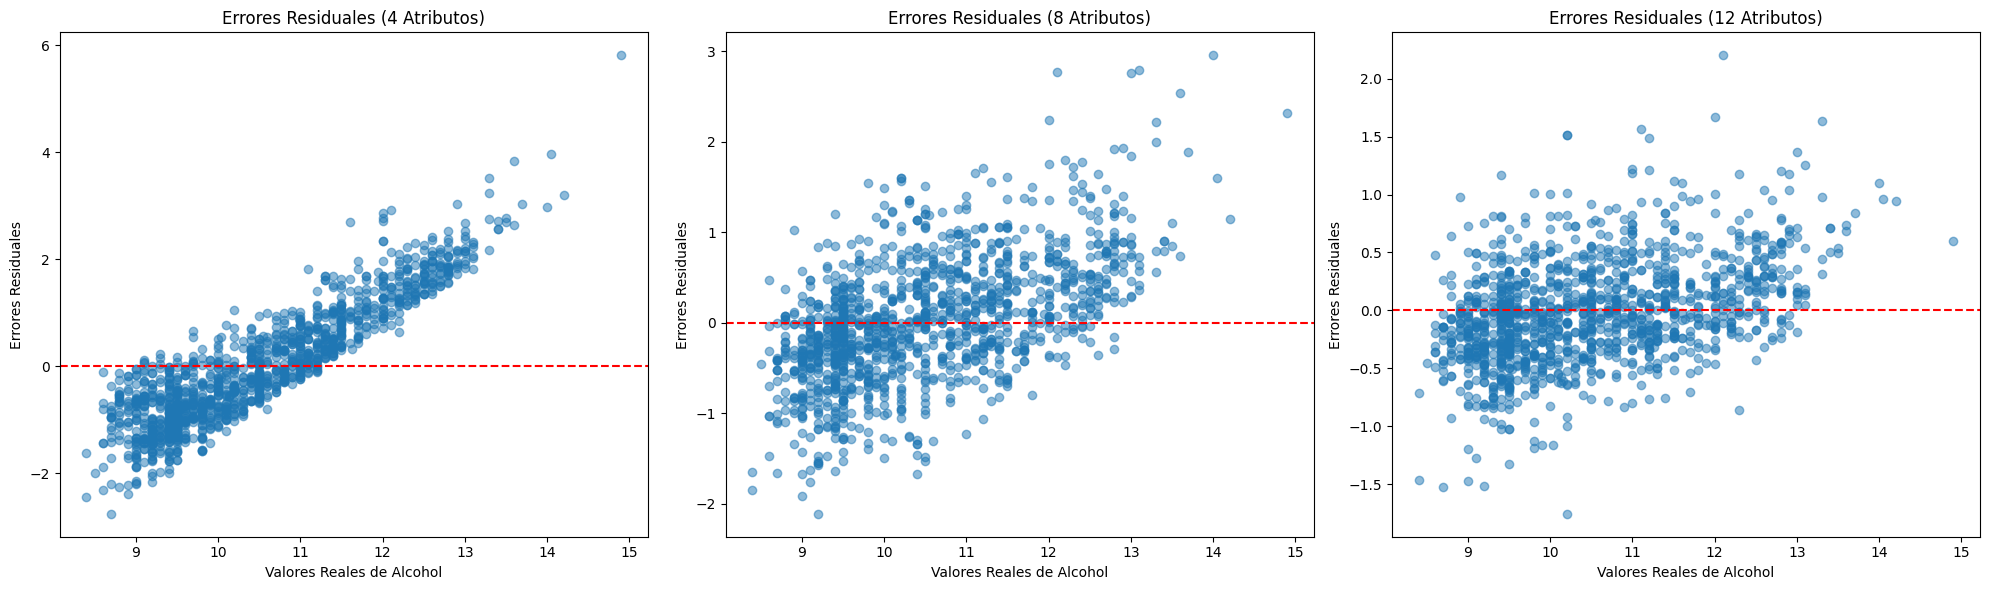

In [ ]:
# Calculamos los errores residuales para cada modelo
errores_residuales_4 = y_test_4 - y_pred_4
errores_residuales_8 = y_test_8 - y_pred_8
errores_residuales_12 = y_test_12 - y_pred_12

# Creamos un gráfico de los errores residuales
plt.figure(figsize=(20, 6))

# Gráfico de errores residuales para el modelo con 4 atributos
plt.subplot(1, 3, 1)
plt.scatter(y_test_4, errores_residuales_4, alpha=0.5)
plt.title('Errores Residuales (4 Atributos)')
plt.xlabel('Valores Reales de Alcohol')
plt.ylabel('Errores Residuales')
plt.axhline(0, color='red', linestyle='--')

# Gráfico de errores residuales para el modelo con 8 atributos
plt.subplot(1, 3, 2)
plt.scatter(y_test_8, errores_residuales_8, alpha=0.5)
plt.title('Errores Residuales (8 Atributos)')
plt.xlabel('Valores Reales de Alcohol')
plt.ylabel('Errores Residuales')
plt.axhline(0, color='red', linestyle='--')

# Gráfico de errores residuales para el modelo con 12 atributos
plt.subplot(1, 3, 3)
plt.scatter(y_test_12, errores_residuales_12, alpha=0.5)
plt.title('Errores Residuales (12 Atributos)')
plt.xlabel('Valores Reales de Alcohol')
plt.ylabel('Errores Residuales')
plt.axhline(0, color='red', linestyle='--')

plt.tight_layout()
plt.show()

- **Modelo de 4 Atributos**: Los errores residuales muestran una tendencia a aumentar a medida que aumentan los valores reales de alcohol. Esto sugiere que el modelo puede estar subestimando o sobreestimando los valores más altos de alcohol, indicativo de una posible falta de variables explicativas que afectan directamente estos rangos.

- ** Modelo de 8 Atributos**: Los residuos en este modelo parecen estar más centrados en torno a la línea cero, aunque todavía presentan cierta dispersión. Esto indica una mejora en la precisión del modelo en comparación con el modelo de 4 atributos, posiblemente debido a la inclusión de variables adicionales que capturan más efectivamente la variabilidad en los datos de alcohol.

- **Modelo de 12 Atributos**: Los residuos para este modelo son notablemente más contenidos cerca de la línea cero y muestran la menor dispersión de los tres modelos. Esto refleja la mayor precisión y eficacia del modelo con 12 atributos, que, al integrar una gama más amplia de variables, logra una mejor estimación del contenido de alcohol en los vinos.

**5) Calcular los intervalos de confianza para cada uno de los coeficientes de regresión con un intervalo de confianza del 75% y explica el resultado obtenido.**

En este apartado, nos enfocamos en calcular los intervalos de confianza para los coeficientes de regresión de diferentes modelos. Utilizamos un intervalo de confianza del 75%, lo que implica que tenemos un nivel de confianza del 75% en que el intervalo captura el verdadero valor del coeficiente de regresión en la población.

Al calcular estos intervalos de confianza, podemos comprender la incertidumbre asociada con cada coeficiente de regresión. Un intervalo de confianza más amplio indica mayor incertidumbre, mientras que un intervalo más estrecho sugiere mayor precisión en la estimación del coeficiente.

In [ ]:
def bootstrap_confidence_interval(model, X, y, iterations=1000, ci=75):
    coefs = []
    for _ in range(iterations):
        X_sample, y_sample = resample(X, y)
        model_clone = clone(model)
        model_clone.fit(X_sample, y_sample)
        coefs.append(model_clone.named_steps['sgdregressor'].coef_)

    coefs = np.array(coefs)
    lower_bound = np.percentile(coefs, (100 - ci) / 2, axis=0)
    upper_bound = np.percentile(coefs, 100 - (100 - ci) / 2, axis=0)

    return lower_bound, upper_bound

# Aplicamos la funcion a los modelos.
lower_bounds_4, upper_bounds_4 = bootstrap_confidence_interval(modelo_4, X_train_4, y_train_4)
lower_bounds_8, upper_bounds_8 = bootstrap_confidence_interval(modelo_8, X_train_8, y_train_8)
lower_bounds_12, upper_bounds_12 = bootstrap_confidence_interval(modelo_12, X_train_12, y_train_12)

print("Intervalos de Confianza del 75% para los coeficientes del modelo de 4 atributos:")
for i, (lower, upper) in enumerate(zip(lower_bounds_4, upper_bounds_4)):
    print(f"Coeficiente {i+1}: {lower:.4f} a {upper:.4f}")

print('\n')

print("Intervalos de Confianza del 75% para los coeficientes del modelo de 8 atributos:")
for i, (lower, upper) in enumerate(zip(lower_bounds_8, upper_bounds_8)):
    print(f"Coeficiente {i+1}: {lower:.4f} a {upper:.4f}")

print('\n')

print("Intervalos de Confianza del 75% para los coeficientes del modelo de 12 atributos:")
for i, (lower, upper) in enumerate(zip(lower_bounds_12, upper_bounds_12)):
    print(f"Coeficiente {i+1}: {lower:.4f} a {upper:.4f}")

Intervalos de Confianza del 75% para los coeficientes del modelo de 4 atributos:
Coeficiente 1: -0.2099 a -0.1561
Coeficiente 2: -0.0982 a -0.0501
Coeficiente 3: 0.0550 a 0.1123
Coeficiente 4: -0.5105 a -0.4663


Intervalos de Confianza del 75% para los coeficientes del modelo de 8 atributos:
Coeficiente 1: 0.3845 a 0.4344
Coeficiente 2: 0.2299 a 0.2663
Coeficiente 3: 0.0478 a 0.0878
Coeficiente 4: 0.5321 a 0.5751
Coeficiente 5: -0.0566 a -0.0233
Coeficiente 6: 0.0363 a 0.0698
Coeficiente 7: -0.4010 a -0.3608
Coeficiente 8: -1.3964 a -1.3441


Intervalos de Confianza del 75% para los coeficientes del modelo de 12 atributos:
Coeficiente 1: 0.6452 a 0.6982
Coeficiente 2: 0.0941 a 0.1275
Coeficiente 3: 0.0603 a 0.0832
Coeficiente 4: 1.0267 a 1.0723
Coeficiente 5: -0.0367 a -0.0077
Coeficiente 6: -0.0626 a -0.0399
Coeficiente 7: -0.0078 a 0.0294
Coeficiente 8: -1.9949 a -1.9351
Coeficiente 9: 0.3900 a 0.4184
Coeficiente 10: 0.1344 a 0.1589
Coeficiente 11: 0.0672 a 0.0895
Coeficiente 12: -0

Una vez tenemos los intervalos de confianza para cada uno de los coeficientes de las tres regresiones lineales, podemos graficarlo para entenderlo mejor.

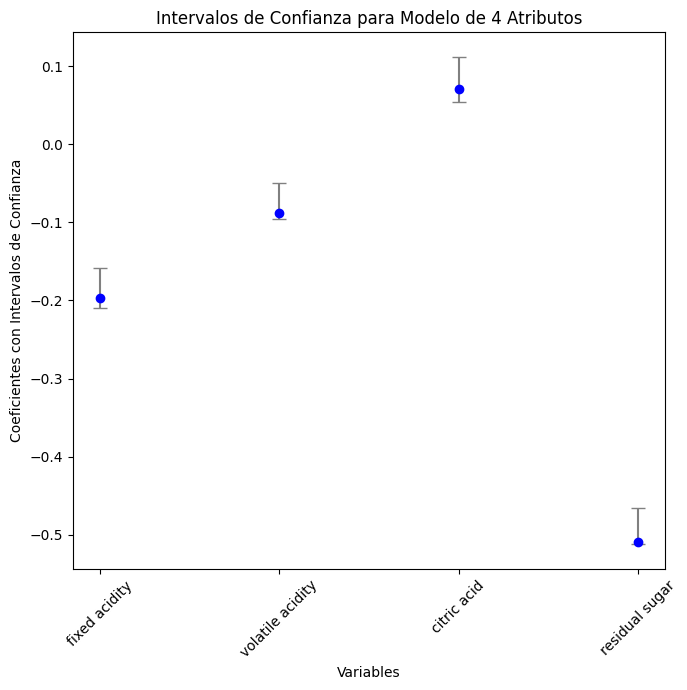

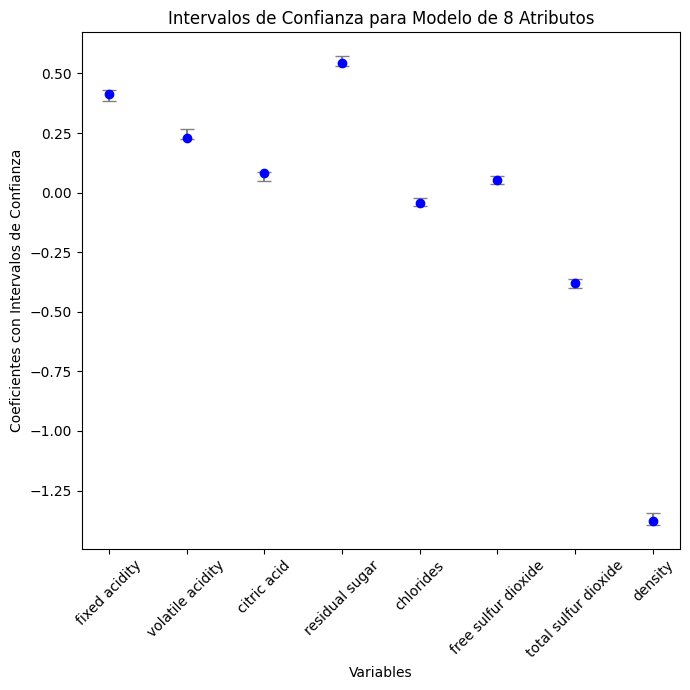

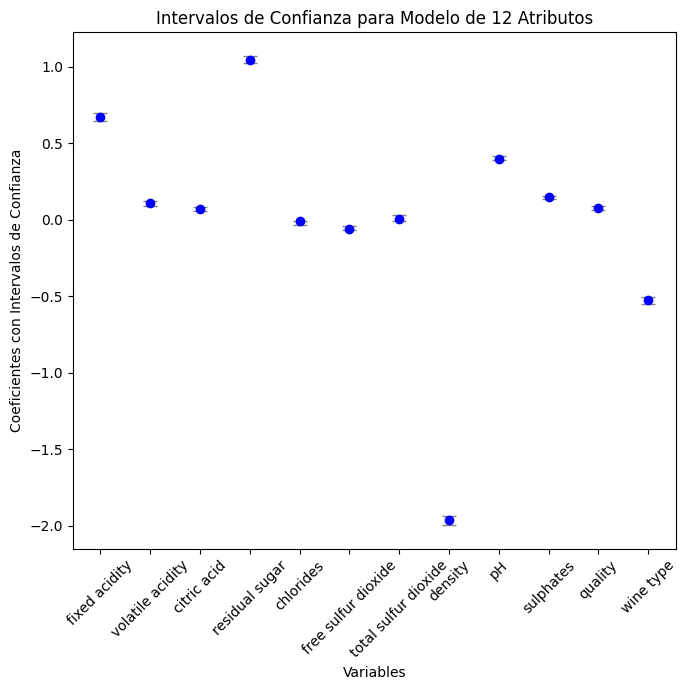

In [ ]:
# Creamos una funcionque grafica los resultados anteriores.
def plot_coefficient_intervals(coefs, lower_bounds, upper_bounds, feature_names, title):
    # Centro de cada barra en el gráfico.
    indices = range(len(coefs))

    # Tamaño de los errores.
    errors = [coefs - lower_bounds, upper_bounds - coefs]
    errors = [np.abs(errors[0]), np.abs(errors[1])]  # Tomar valor absoluto para evitar negativos

    plt.figure(figsize=(7, 7))
    plt.errorbar(indices, coefs, yerr=errors, fmt='o', color='b', ecolor='gray', capsize=5)
    plt.title(title)
    plt.xlabel('Variables')
    plt.ylabel('Coeficientes con Intervalos de Confianza')
    plt.xticks(indices, feature_names, rotation=45)
    plt.tight_layout()
    plt.show()

# MODELO 4 VARIABLES.
coeficientes_4 = modelo_4.named_steps['sgdregressor'].coef_
lower_bounds_4, upper_bounds_4 = bootstrap_confidence_interval(modelo_4, X_train_4, y_train_4)

feature_names_4 = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar']

plot_coefficient_intervals(coeficientes_4, lower_bounds_4, upper_bounds_4, feature_names_4, 'Intervalos de Confianza para Modelo de 4 Atributos')

# MODELO 8 VARIABLES.
coeficientes_8 = modelo_8.named_steps['sgdregressor'].coef_
lower_bounds_8, upper_bounds_8 = bootstrap_confidence_interval(modelo_8, X_train_8, y_train_8)

feature_names_8 = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density']

plot_coefficient_intervals(coeficientes_8, lower_bounds_8, upper_bounds_8, feature_names_8, 'Intervalos de Confianza para Modelo de 8 Atributos')

# MODELO 12 VARIABLES.
coeficientes_12 = modelo_12.named_steps['sgdregressor'].coef_
lower_bounds_12, upper_bounds_12 = bootstrap_confidence_interval(modelo_12, X_train_12, y_train_12)

feature_names_12 = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'quality', 'wine type']

plot_coefficient_intervals(coeficientes_12, lower_bounds_12, upper_bounds_12, feature_names_12, 'Intervalos de Confianza para Modelo de 12 Atributos')

---
Como conclusión al desarrollo y evaluación de modelos para predecir el grado de alcohol en vinos, los análisis revelaron que aumentar el número de atributos mejora la precisión de las predicciones, como se evidencia en la disminución de errores cuadráticos y absolutos medios y en la concentración de los errores residuales cerca de cero. Sin embargo, es crucial equilibrar la inclusión de variables para evitar el sobreajuste y asegurar que cada atributo contribuya significativamente al poder predictivo del modelo.

#Ejercicio 3 (Agrupamiento)
La empresa productora de vinos no está segura de que la empresa de analiza la calidad de los diferentes vinos esté realizando el trabajo adecuadamente por lo que ha decidido analizar si los diferentes vinos que han sido producidos en los últimos años realmente tienen la calidad identificada.

Para ello se debe aplicar un algoritmo de agrupamiento para comprobar si los vinos realmente se agrupan de manera similar a como han sido valorados por la empresa evaluadora (quality) y realizar las siguientes acciones:

1) Realizar todo el proceso de preparación, limpieza, eliminación y análisis de los datos con el objetivo de identificar aquellas variables candidatas para el proceso de agrupamiento (0.5 puntos).

2) Ejecutar diferentes procesos de agrupamiento utilizando el algoritmo K-Means e identificar cual es el valor de k que mejor resultados ofrece (1 punto). En necesario justificar la selección del mejor valor de k mediante la utilización de datos empíricos.

3) Analiza los clústeres obtenidos para el mejor valor de k y responde a las siguientes preguntas:


  • ¿Existe algún tipo de similitud entre los grupos obtenidos y los valores de la variable quality del
dataset? (0.5 puntos).

  • ¿Cómo se diferencian los clústeres entre sí? (0.5 puntos).
En necesario justificar las respuestas mediante la utilización de datos empíricos

---

**1) Realizar todo el proceso de preparación, limpieza, eliminación y análisis de los datos con el objetivo de identificar aquellas variables candidatas para el proceso de agrupamiento (0.5 puntos).**



In [61]:
# Carga del dataset
datos = pd.read_csv('wine_alcohol.csv',delimiter=';' )

# Exploración inicial
print(datos.head())  # Visualizar las primeras filas para entender la estructura de los datos

print(datos.info())

   id  fixed acidity  volatile acidity  citric acid  residual sugar  \
0   0            7.4              0.70         0.00             1.9   
1   1            7.8              0.88         0.00             2.6   
2   2            7.8              0.76         0.04             2.3   
3   3           11.2              0.28         0.56             1.9   
4   4            7.4              0.70         0.00             1.9   

   chlorides  free sulfur dioxide  total sulfur dioxide  density    pH  \
0      0.076                 11.0                  34.0   0.9978  3.51   
1      0.098                 25.0                  67.0   0.9968  3.20   
2      0.092                 15.0                  54.0   0.9970  3.26   
3      0.075                 17.0                  60.0   0.9980  3.16   
4      0.076                 11.0                  34.0   0.9978  3.51   

   sulphates  quality  wine type  alcohol  
0       0.56        5          1      9.4  
1       0.68        5          1      9.

Observamos que no hay valores no nulos (no hace falta elimiar valores Nan). Lo siguiente que hacemos el eliminar la columna de ID, ya que no nos es relevante. Posteriormente pasamos a analizar los outliers al igual que se ha hecho en el primer apartado del ejercicio 1.

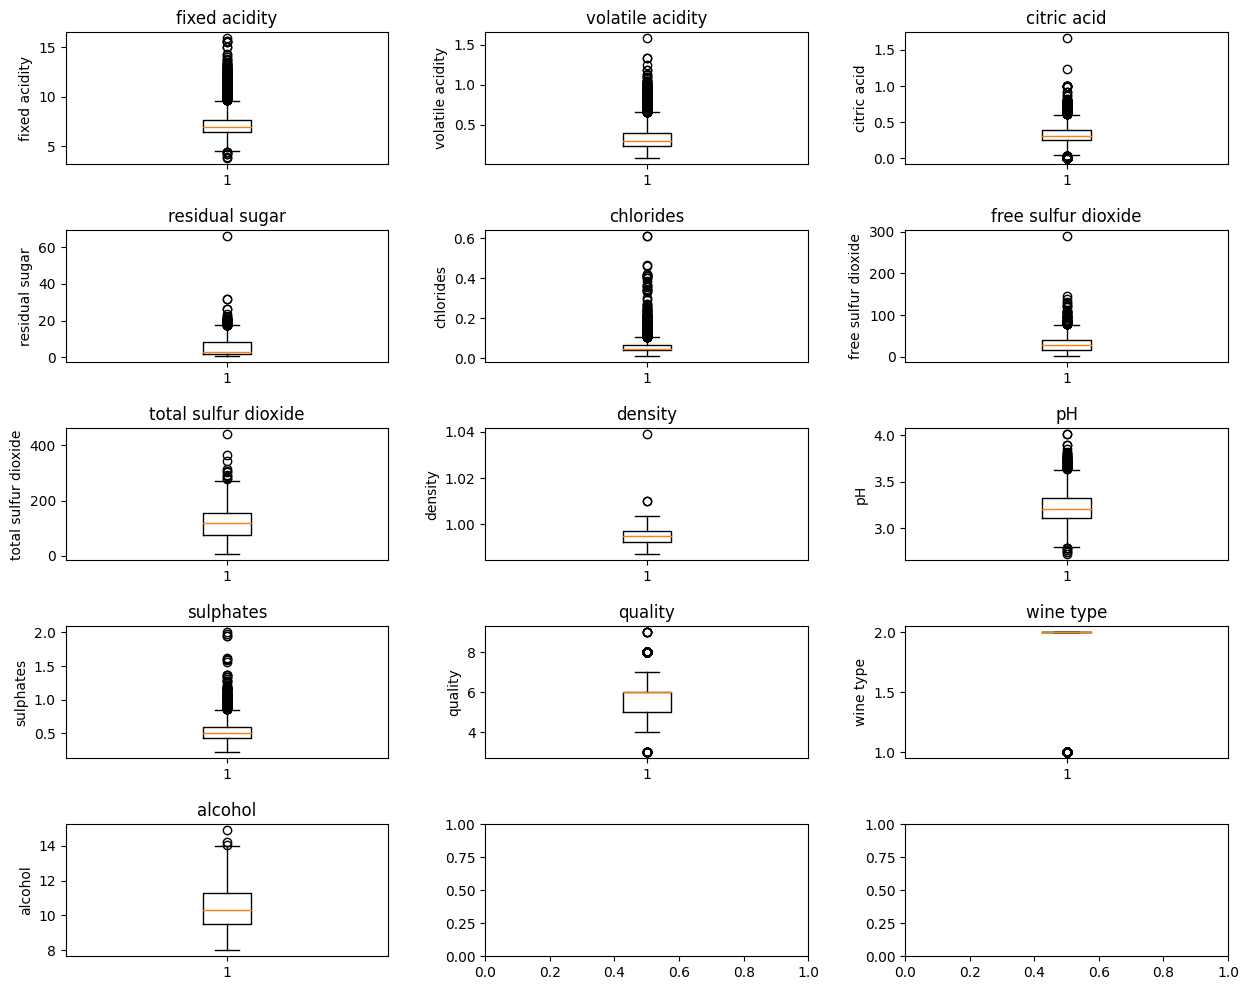

Variable             IQR             Outliers
----------------------------------------
fixed acidity        1.30            357
volatile acidity     0.17            377
citric acid          0.14            509
residual sugar       6.30            118
chlorides            0.03            286
free sulfur dioxide  24.00           62
total sulfur dioxide 79.00           10
density              0.00            3
pH                   0.21            73
sulphates            0.17            191
quality              1.00            228
wine type            0.00            1599
alcohol              1.80            3
       fixed acidity  volatile acidity  citric acid  residual sugar  \
count    6497.000000       6497.000000  6497.000000     6497.000000   
mean        7.215307          0.339666     0.318633        5.443235   
std         1.296434          0.164636     0.145318        4.757804   
min         3.800000          0.080000     0.000000        0.600000   
25%         6.400000          0

In [62]:
# Eliminamos la columna ID que no nos aporta nada.
datos.drop('id', axis=1, inplace=True)
datos.head()


variables = datos.columns

fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(15, 12))
fig.subplots_adjust(hspace=0.5, wspace=0.3) #Espacio entre graficass

outlier_data = []

for i, var in enumerate(variables):
    ax = axes[i // 3, i % 3]
    ax.boxplot(datos[var].dropna())
    ax.set_title(var)
    ax.set_ylabel(var)

    # Cálculo de cuartiles y valores atípicos
    Q1 = datos[var].quantile(0.25)
    Q3 = datos[var].quantile(0.75)
    IQR = Q3 - Q1
    outliers = datos[(datos[var] < (Q1 - 1.5 * IQR)) | (datos[var] > (Q3 + 1.5 * IQR))]
    outlier_count = len(outliers)

    outlier_data.append((var, f"{IQR:.2f}", outlier_count))

plt.show()

# Mostrar información sobre valores atípicos
print(f"{'Variable':<20} {'IQR':<15} {'Outliers'}")
print('-' * 40)
for var, iqr, count in outlier_data:
    print(f"{var:<20} {iqr:<15} {count}")




# Obtenemos estadísticas descriptivas de los datos.
estadisticas = datos.describe()
print(estadisticas)


Observamos que los outliers en density son los más significativos, por lo que los vamos a eliminar. En el resto de variables, pese a presentar también outliers, se encuentran entre valores bastante realistas que están a corde con el campo que se está tratando. Por otro lado, destacar que existe un pequeño desvalanceo en la variable wine type.

In [63]:
#Calculamso el rango intercuartilico de density
Q1_density = datos['density'].quantile(0.25)
Q3_density = datos['density'].quantile(0.75)
IQR_density = Q3_density - Q1_density

#Outliers
lower_bound = Q1_density - 1.5 * IQR_density
upper_bound = Q3_density + 1.5 * IQR_density

#ELiminamos outiers
datos = datos[(datos['density'] >= lower_bound) & (datos['density'] <= upper_bound)]

Para aplicar k-Means vamos a normalizar los datos para tratar de mejorar el modelo y a su vez poder manejar mejor las escalas de los datos

In [64]:
scaler = StandardScaler()
datos_scaled = scaler.fit_transform(datos)
datos_scaled = pd.DataFrame(datos_scaled, columns=datos.columns)


Pasamos a estudiar las correlaciones para poder selecionar las variables que nos interesan porque es posible que algunas variables estén altamente correlacionadas entre sí, lo que podría redundar en información similar.

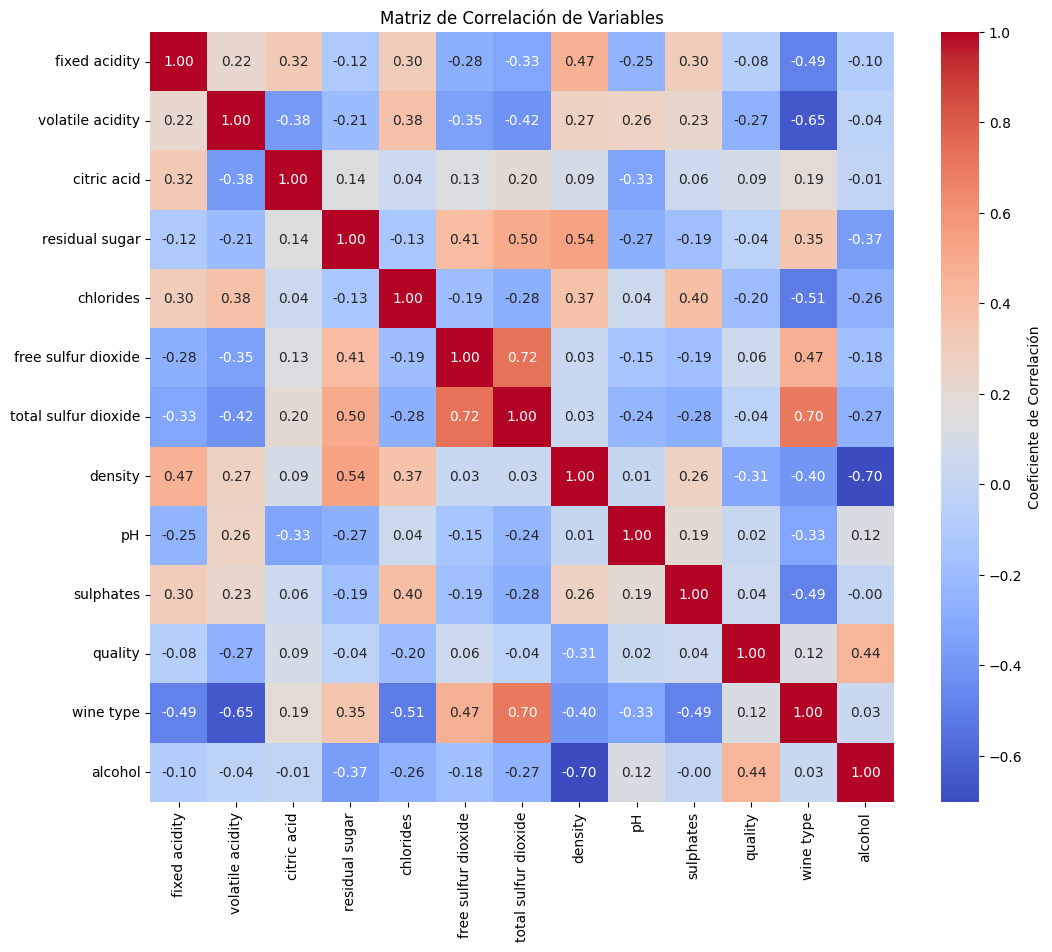

In [65]:
plt.figure(figsize=(12, 10))

corr_matrix = datos.corr()

sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar_kws={'label': 'Coeficiente de Correlación'})
plt.title("Matriz de Correlación de Variables")
plt.show()



Se observa que la correlación entre la mayoría de las variables no es muy significativa, excepto en el caso de "free sulfur dioxide" y "total sulfur dioxide", que muestran la correlación más alta. Además, considerando el contexto, esta correlación tiene sentido dado que ambas variables están relacionadas con el dióxido de azufre en el vino. Por otro lado, la variable Quality tampoco va a ser usada ya que se va a utilizar para comparar en los siguientes apartados.

**2) Ejecutar diferentes procesos de agrupamiento utilizando el algoritmo K-Means e identificar cual es el valor de k que mejor resultados ofrece (1 punto). En necesario justificar la selección del mejor valor de k mediante la utilización de datos empíricos.**

Pasamos a realizar una prueba de diferentes valores de k en el algoritmo K-Means para determinar el número óptimo de clústeres utilizando dos métricas: inercia y coeficiente de silueta.

In [66]:
X = datos_scaled[['fixed acidity', 'volatile acidity', 'citric acid','residual sugar','chlorides' ,'total sulfur dioxide',
           'pH', 'sulphates', 'alcohol', 'wine type', 'density']]
#X = datos[['total sulfur dioxide', 'pH', 'fixed acidity']]
#X = datos[['fixed acidity', 'residual sugar', 'free sulfur dioxide', 'pH']]


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

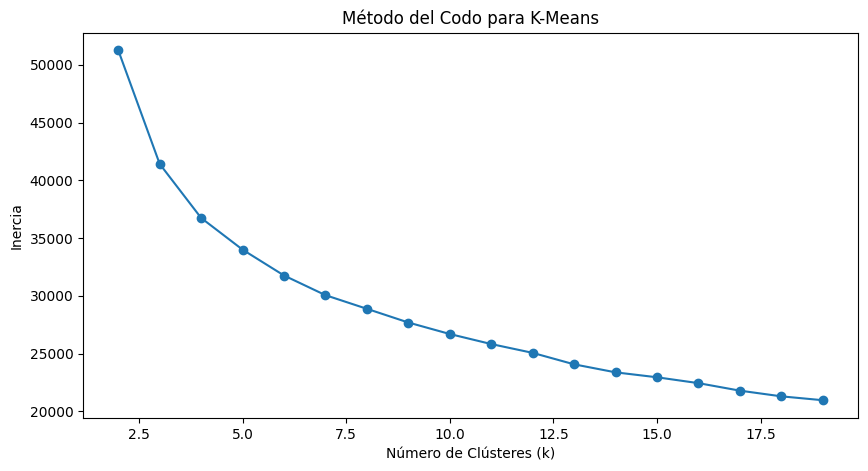

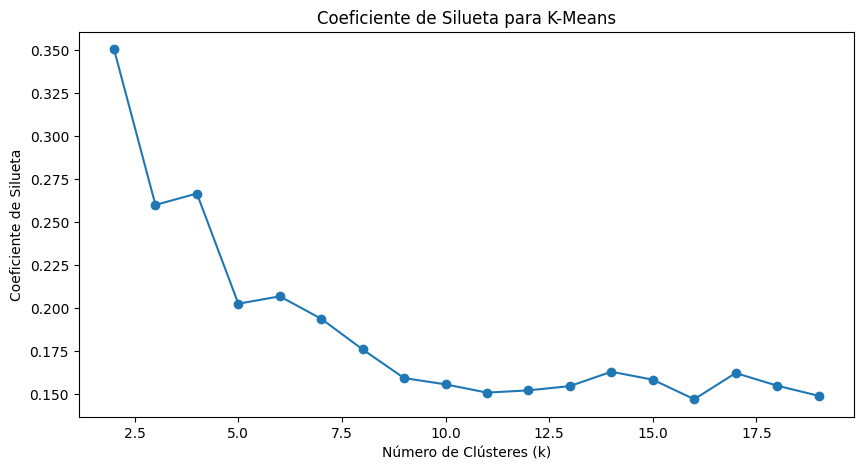

In [67]:
# Prueba de diferentes valores de k
inertias = []
silhouette_scores = []

for k in range(2, 20):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X, kmeans.labels_))

# Visualización de la inercia y el coeficiente de silueta para cada k
plt.figure(figsize=(10, 5))
plt.plot(range(2, 20), inertias, marker='o')
plt.xlabel('Número de Clústeres (k)')
plt.ylabel('Inercia')
plt.title('Método del Codo para K-Means')
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(range(2, 20), silhouette_scores, marker='o')
plt.xlabel('Número de Clústeres (k)')
plt.ylabel('Coeficiente de Silueta')
plt.title('Coeficiente de Silueta para K-Means')
plt.show()


Las dos gráficas muestran lo siguiente:

1. Método del Codo (Elbow Method):
El gráfico de inercia (suma de las distancias cuadradas dentro de cada clúster) muestra una curva descendente. El "punto codo" en este gráfico es donde la disminución de la inercia comienza a nivelarse. Este punto sugiere el número óptimo de clústeres, ya que agregar más clústeres no proporciona una reducción significativa en la inercia.
2. Coeficiente de Silueta (Silhouette Coefficient):
El gráfico del coeficiente de silueta muestra cómo se comporta la coherencia dentro de los clústeres en relación con la separación entre clústeres. Un valor alto de coeficiente de silueta para un valor particular de k indica una agrupación más coherente y distinta. El valor máximo de coeficiente de silueta sugiere el número óptimo de clústeres.

Teniendo en cuenta ambos gráficos, podemos selecionar un k = 6.

 **3) Analiza los clústeres obtenidos para el mejor valor de k y responde a las siguientes preguntas:**

**• ¿Existe algún tipo de similitud entre los grupos obtenidos y los valores de la variable quality del
dataset? (0.5 puntos).**

**• ¿Cómo se diferencian los clústeres entre sí? (0.5 puntos).**

**En necesario justificar las respuestas mediante la utilización de datos empíricos.**

In [68]:
# Aplicar K-Means con el mejor valor de k

kmeans_final = KMeans(n_clusters=6, random_state=42)
kmeans_final.fit(X)

# Añadir los resultados al dataset original
datos_scaled['cluster'] = kmeans_final.labels_

# Análisis de los clústeres
cluster_means = datos_scaled.groupby('cluster').mean()
print(cluster_means)

#esto se utiliza en el ejercicio 4
X['cluster'] = kmeans_final.labels_

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


         fixed acidity  volatile acidity  citric acid  residual sugar  \
cluster                                                                 
0            -0.135505         -0.347101     0.317683        1.493006   
1            -0.349989         -0.360391     0.066829       -0.436851   
2             2.019446          0.445881     0.922236       -0.577765   
3             0.091126          1.651536    -1.230102       -0.646805   
4             0.764841          1.118244     1.225526       -0.495907   
5            -0.341764         -0.430316    -0.034915       -0.324016   

         chlorides  free sulfur dioxide  total sulfur dioxide   density  \
cluster                                                                   
0        -0.189250             0.807831              0.939559  0.925427   
1        -0.571133            -0.063662             -0.091599 -1.226117   
2         0.858798            -0.890610             -1.293908  0.995334   
3         0.696496            -0.794402 

<ipython-input-68-c05e1842b2e0>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['cluster'] = kmeans_final.labels_


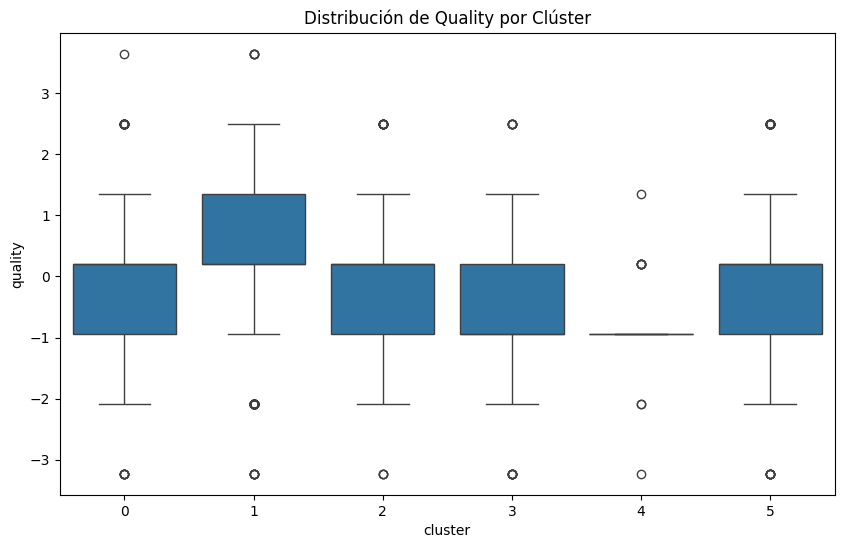

In [69]:
# Gráfico de Boxplot de 'quality' por clúster
plt.figure(figsize=(10, 6))
sns.boxplot(x='cluster', y='quality', data=datos_scaled)
plt.title('Distribución de Quality por Clúster')
plt.show()



Al analizar los grupos generados por el algoritmo de agrupamiento y su relación con la variable quality en el dataset, se observa una falta de asociación significativa entre los clústeres y los valores de calidad del vino. Esto se evidencia a través de varias observaciones:

- Medias de la Variable quality por Clúster: Al calcular las medias de la variable quality para cada clúster, se observa que las diferencias entre las medias no son pronunciadas. Esto sugiere que los grupos generados no están fuertemente relacionados con los distintos niveles de calidad del vino.
- Boxplots de quality por Clúster: Al graficar boxplots de la variable quality para cada clúster, se observa una superposición considerable de los rangos intercuartílicos (IQR) entre los distintos clústeres. Los boxplots no muestran diferencias significativas en la distribución de los valores de quality entre los grupos.

Estos hallazgos indican que, a pesar de la agrupación realizada por el algoritmo, no se establece una relación clara entre los grupos identificados y los niveles de calidad del vino.

Por último gráficamos la calidad según algunas variables para confrimar que de verdad no existe ninguna relación entre la calidad y las variables de nuestro modelo. (se ha probado con el resto de variables y también se observa que no hay relación).

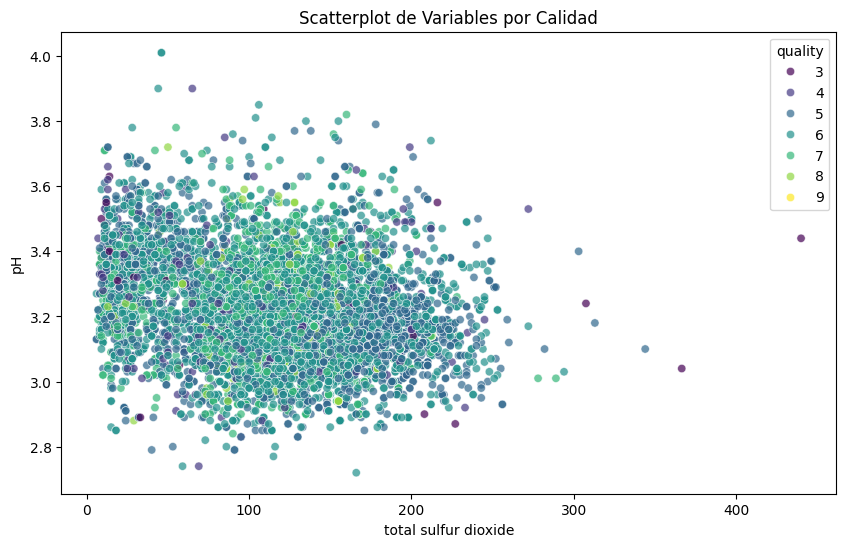

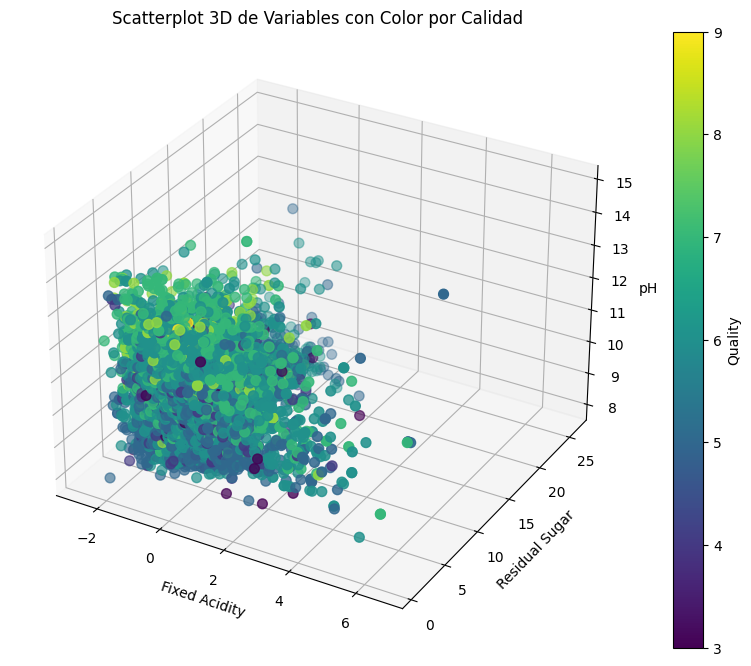

In [70]:
plt.figure(figsize=(10, 6))


sns.scatterplot(x='total sulfur dioxide', y='pH', hue='quality', data=datos, palette='viridis', alpha=0.7)
plt.title('Scatterplot de Variables por Calidad')
plt.show()

# Crea una figura tridimensional
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Gráfico de dispersión tridimensional
scatter = ax.scatter(X['fixed acidity'], datos['residual sugar'], datos['alcohol'], c=datos['quality'], cmap='viridis', s=50)

# Añade etiquetas y título
ax.set_xlabel('Fixed Acidity')
ax.set_ylabel('Residual Sugar')
ax.set_zlabel('pH')
ax.set_title('Scatterplot 3D de Variables con Color por Calidad')

# Añade una barra de color
cbar = plt.colorbar(scatter)
cbar.set_label('Quality')

# Muestra el gráfico
plt.show()

Respecto a como se diferencian los clusters, podemos analizar las medias calculadas anteriormente y se puede llegar a las siguientes conclusiones:

- Residual Sugar (residual sugar):
El cluster 0 tiene la media más alta de residual sugar (12.57), lo que sugiere que este atributo es característico de este grupo en particular.

- Alcohol (alcohol):
El cluster 2 tiene la media más alta de alcohol (11.87), lo que indica que este atributo podría ser importante para diferenciar este cluster de los demás.

- pH (pH): Los clusters 1 y 3 muestran valores de pH (3.38 y 3.22 respectivamente) que difieren notablemente de otros clusters, lo que podría indicar que el pH es un factor relevante en la agrupación.

- Sulphates (sulphates): El cluster 5 muestra una media significativamente más alta de sulphates (1.07), lo que puede ser distintivo de este grupo.

- Volatile Acidity (volatile acidity): El cluster 1 tiene una media mucho más alta de volatile acidity (0.61) en comparación con otros clusters, lo que sugiere que este atributo es relevante para diferenciar este cluster en particular.

- Citric Acid (citric acid): Aunque las diferencias no son tan marcadas, el cluster 2 muestra una media ligeramente más alta de citric acid (0.33), lo que puede contribuir a su agrupación.

Los vinos con altos niveles de alcohol, agrupados en el clúster 2, pueden estar dirigidos a un tipo particular de consumidor.
Los vinos con altos niveles de azúcar residual, agrupados en el clúster 0, podrían representar una variedad más dulce, como vinos de postre.

En este primer gráfico podemos observar que, como se ha mencionado antes, el cluster 0 es el que tiene mayor media de residual sugar.

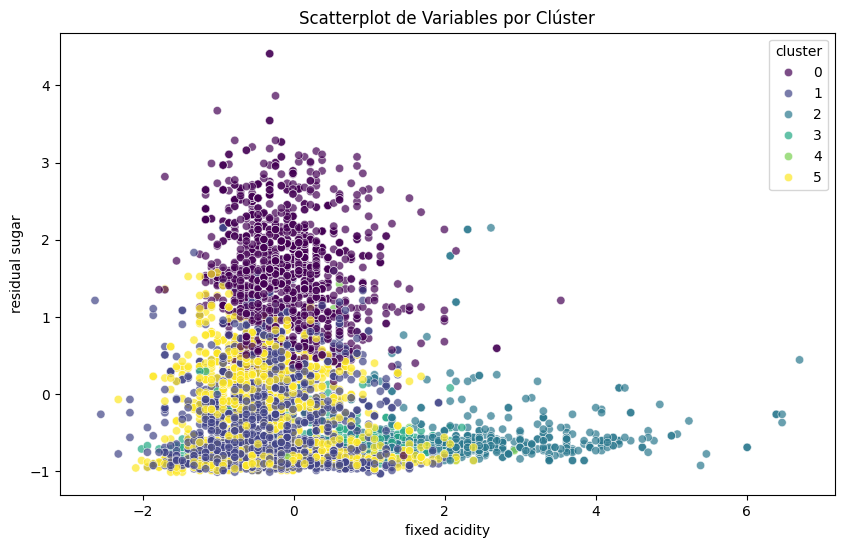

In [71]:
# Gráfico de Scatterplot 2D (ejemplo con dos variables)
plt.figure(figsize=(10, 6))
sns.scatterplot(x='fixed acidity', y='residual sugar', hue='cluster', data=X, palette='viridis', alpha=0.7)
plt.title('Scatterplot de Variables por Clúster')
plt.show()

Gráficamos también en tres dimensiones, y añadimos la variable alcohol. Podemos ver que el segundo cluster tiene mayor media en alcohol como se ha mencionado antes.

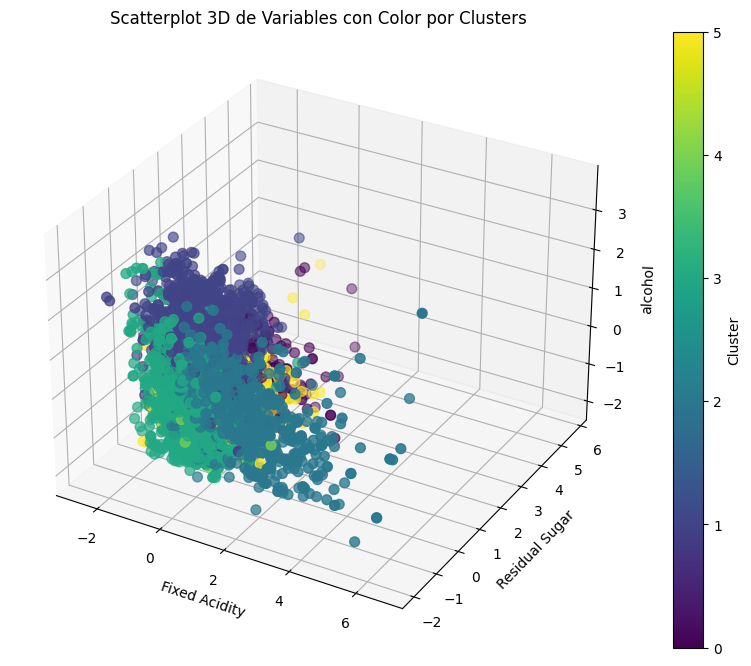

In [72]:
# Crea una figura tridimensional
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Gráfico de dispersión tridimensional
scatter = ax.scatter(X['fixed acidity'], X['total sulfur dioxide'], X['alcohol'], c=X['cluster'], cmap='viridis', s=50)

# Añade etiquetas y título
ax.set_xlabel('Fixed Acidity')
ax.set_ylabel('Residual Sugar')
ax.set_zlabel('alcohol')
ax.set_title('Scatterplot 3D de Variables con Color por Clusters')

# Añade una barra de color
cbar = plt.colorbar(scatter)
cbar.set_label('Cluster')

# Muestra el gráfico
plt.show()

Por último, vamos a realizar una redución de dimensionalidad para poder graficar mejor los clusters. Se observa como están de separados los clusters.

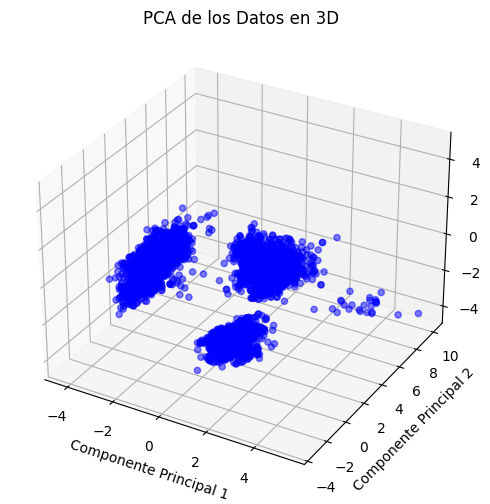

In [73]:
# Crear un objeto PCA con 3 componentes (para visualizar en 3D)
pca = PCA(n_components=3)

X_pca = pca.fit_transform(X)

# Crear una figura y un eje 3D
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Graficar los datos en 3D
ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c='b', marker='o', alpha=0.5)

# Configurar etiquetas de los ejes
ax.set_xlabel('Componente Principal 1')
ax.set_ylabel('Componente Principal 2')
ax.set_zlabel('Componente Principal 3')
ax.set_title('PCA de los Datos en 3D')

# Mostrar la gráfica
plt.show()

#Ejercicio 4 (Agrupamiento)

La empresa productora de vinos desea mejorar el proceso de producción de sus vinos con el objetivo de mejorar las futuras producciones.
Para ello han pensado en utilizar un algoritmo de agrupamiento jerárquico para segmentar los diferentes vinos en base a sus componentes, calidad y nivel de alcohol.

1) Dado el mejor valor de k del apartado anterior selecciona los 10 ejemplos más representativos de cada clúster para generar un nuevo dataset y aplicar agrupamiento jerárquico y responder a las siguientes preguntas:

  • ¿Cuál ha sido tu criterio para seleccionar los ejemplos más representativos de cada clúster? (0,5 puntos).

2) Seleccionar un algoritmo de agrupamiento jerárquico y generar los diferentes clústeres en base a los atributos seleccionados (0.75 puntos).

3) Generar y analizar el dendrograma resultante del proceso de agrupamiento. (0,75 puntos)

---

**1) Dado el mejor valor de k del apartado anterior selecciona los 10 ejemplos más representativos de cada clúster para generar un nuevo dataset y aplicar agrupamiento jerárquico y responder a las siguientes preguntas: ¿Cuál ha sido tu criterio para seleccionar los ejemplos más representativos de cada clúster? (0,5 puntos).**

Para seleccionar los ejemplos más representativos de cada clúster, usamos una estrategia basada en la distancia de cada punto al centroide del clúster.

Calculamos manualmente las distancias euclidianas entre cada punto y su respectivo centroide. Luego, se identifican y seleccionan los puntos más cercanos (o más representativos) de cada clúster en función de estas distancias.Usamos una función personalizada para calcular los índices de los 10 puntos más cercanos al centroide para cada clúster. Estos puntos seleccionados capturan la estructura y variabilidad de cada grupo de manera efectiva. Por últimos guardamos en una nueva variable los ejemplos más representativos.

In [90]:
centroides = kmeans_final.cluster_centers_
centroides = centroides[centroides[:, -1].argsort()]

# Función para calcular los índices de los 10 puntos más cercanos al centroide para un cluster dado
def indices_puntos_cercanos(data, num_cluster, k=10):
    # Extraer datos del cluster específico
    cluster_data = data[datos_scaled['cluster'] == num_cluster]
    cluster_data.drop('cluster', axis=1, inplace=True)

    # Seleccionar el centroide específico
    centroide = centroides[num_cluster]

    # Calcular distancias desde el centroide a todos los puntos en el cluster
    distancias = [np.sqrt(np.sum((fila.values - centroide)**2)) for index, fila in cluster_data.iterrows()]

    # Encontrar los índices de las 10 menores distancias
    indices_menores = np.argsort(distancias)[:k]

    # Devolver los índices de los puntos más cercanos
    return cluster_data.iloc[indices_menores].index.tolist()

# Lista para almacenar todos los índices de puntos cercanos de todos los clusters
indices_puntos_cercanos_total = []

# Repetir para cada uno de los 6 clusters
for i in range(6):
    indices_puntos_cercanos_total.extend(indices_puntos_cercanos(X, i))

# Crear un DataFrame con los puntos correspondientes a los índices encontrados
puntos_cercanos_df = X.iloc[indices_puntos_cercanos_total]

# Imprimir el DataFrame de puntos cercanos
print(puntos_cercanos_df)

<ipython-input-90-628400d8943c>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_data.drop('cluster', axis=1, inplace=True)
<ipython-input-90-628400d8943c>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_data.drop('cluster', axis=1, inplace=True)
<ipython-input-90-628400d8943c>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_data.drop('cluster', axis=1, inplace=True)
<ipython-input-90-628400d8943c>:8: SettingW

      fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
6324      -0.011574         -0.787778    -0.059202        1.084973  -0.600259   
6253      -0.937102         -0.301393     0.629045        1.149121  -0.229236   
4992       0.142681         -0.301393    -0.265676        1.020826  -0.685880   
6251      -0.937102         -0.301393     0.629045        1.149121  -0.229236   
6250      -0.937102         -0.301393     0.629045        1.149121  -0.229236   
6252      -0.937102         -0.301393     0.629045        1.149121  -0.229236   
1922      -0.320083         -0.362191     0.835519        0.828383  -0.714420   
4745      -0.011574         -0.118998     0.560221        0.700088  -0.514638   
4743      -0.011574         -0.118998     0.560221        0.700088  -0.514638   
4314      -0.320083         -1.091768    -0.196851        1.063591  -0.286317   
4141      -0.242956         -0.118998    -0.128026       -0.775306  -0.571719   
5888      -0.242956         

<ipython-input-90-628400d8943c>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_data.drop('cluster', axis=1, inplace=True)
<ipython-input-90-628400d8943c>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_data.drop('cluster', axis=1, inplace=True)


**2) Seleccionar un algoritmo de agrupamiento jerárquico y generar los diferentes clústeres en base a los atributos seleccionados (0.75 puntos).**

 La principal diferencia entre Kmeans y agrupamiento jerárquico radica en su enfoque para agrupar los datos. K-Means es un algoritmo de agrupamiento no jerárquico que asigna cada punto de datos a uno de k clústeres predefinidos, minimizando la distancia cuadrada entre los puntos y los centroides de los clústeres. Este método requiere especificar el número de clústeres (k) de antemano y es eficiente para grandes conjuntos de datos.

Por otro lado, el clustering jerárquico construye una estructura de clústeres en forma de un árbol jerárquico (dendrograma) sin la necesidad de especificar el número de clústeres de antemano. Este algoritmo puede ser aglomerativo (bottom-up) o divisivo (top-down). En este caso, estamos utilizando el enfoque aglomerativo, donde cada punto comienza como un clúster individual y se van fusionando en clústeres más grandes según la distancia entre ellos.

Cada punto se considera un clúster inicial y en cada paso, se fusionan los dos clústeres más cercanos según alguna métrica de distancia.

In [91]:
# Inicializar el modelo de agrupamiento jerárquico
agg_clustering = AgglomerativeClustering(n_clusters=6)

# Aplicar el agrupamiento jerárquico a los datos seleccionados
cluster_labels_agg = agg_clustering.fit_predict(puntos_cercanos_df)

<ipython-input-92-65d2b69c96b5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  puntos_cercanos_df['agg_cluster'] = cluster_labels_agg


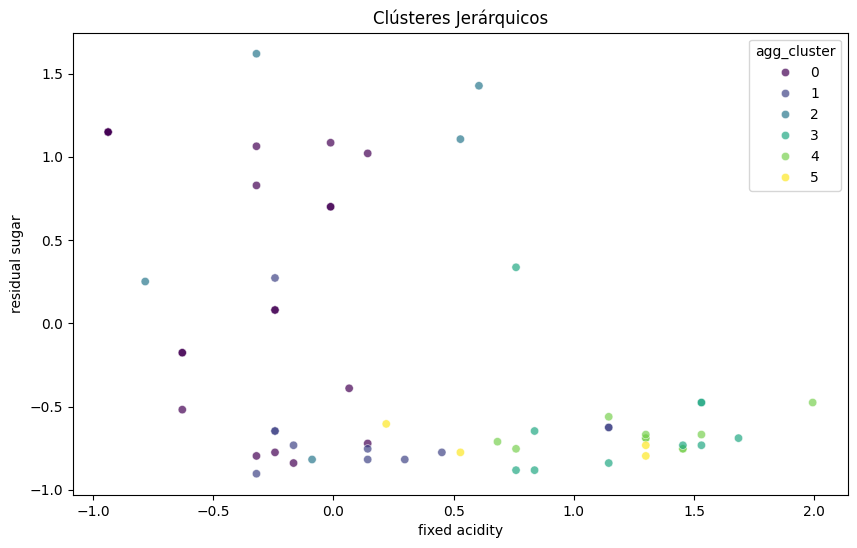

In [92]:
# Añadir las etiquetas de clúster al DataFrame representativo
puntos_cercanos_df['agg_cluster'] = cluster_labels_agg

# Graficar un scatter plot de dos atributos con los nuevos clústeres
plt.figure(figsize=(10, 6))
sns.scatterplot(x='fixed acidity', y='residual sugar', hue='agg_cluster', data=puntos_cercanos_df, palette='viridis', alpha=0.7)
plt.title('Clústeres Jerárquicos')
plt.show()

En esta gráfica podemos ver, aunque solo con dos variables, como más o menos los 60 puntos más significativos están agrupados y diferenciados.
**3) Generar y analizar el dendrograma resultante del proceso de agrupamiento. (0,75 puntos)**


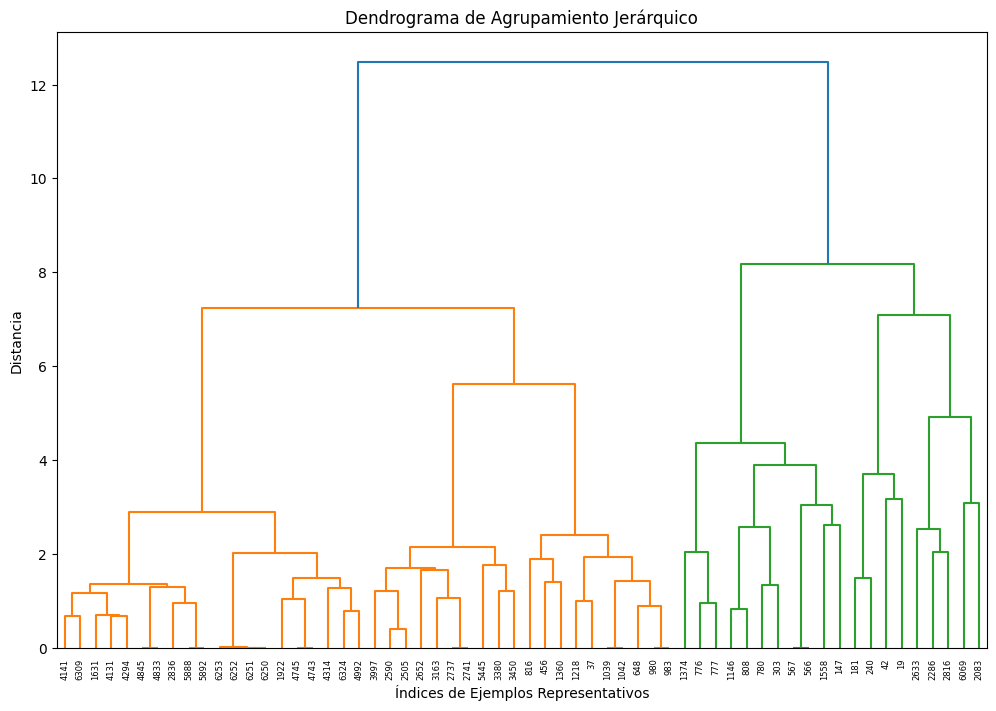

In [93]:
# Calcular la matriz de enlace utilizando el método de enlace completo
linkage_matrix = linkage(puntos_cercanos_df, method='complete')

# Generar el dendrograma
plt.figure(figsize=(12, 8))
dendrogram(linkage_matrix, orientation='top', labels=puntos_cercanos_df.index.tolist(), leaf_rotation=90)
plt.title('Dendrograma de Agrupamiento Jerárquico')
plt.xlabel('Índices de Ejemplos Representativos')
plt.ylabel('Distancia')
plt.show()

Realizamos el dendograma, pero para poder interpretarlo vamos a repetirlo, pero marcando cada índice con un color para diferenciar a que cluster inicial pertence. De esta manera, vemos que los marcados de azul eran de un mismo cluster, de rojo otro y así.

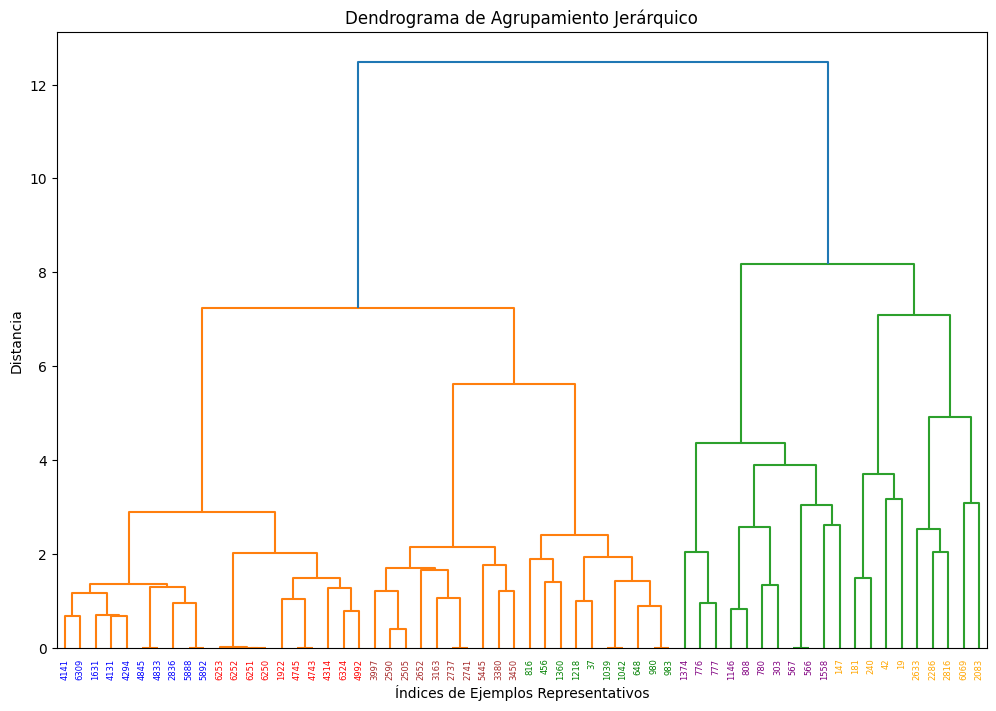

In [100]:
# Calcular la matriz de enlace utilizando el método de enlace completo
linkage_matrix = linkage(puntos_cercanos_df, method='complete')

# Generar el dendrograma
plt.figure(figsize=(12, 8))
dendrogram(linkage_matrix, orientation='top', labels=puntos_cercanos_df.index.tolist(), leaf_rotation=90)
plt.title('Dendrograma de Agrupamiento Jerárquico')


# Mapeo de colores para cada cluster
cluster_colors = {0: 'red', 1: 'blue', 2: 'green', 3: 'purple', 4: 'orange', 5: 'brown'}

# Obtener los objetos de texto en el eje X
labels = plt.gca().get_xticklabels()

# Cambiar el color del texto en el eje X según el cluster
for i, label in enumerate(labels):
    cluster = puntos_cercanos_df.loc[int(label.get_text()), 'cluster']
    label.set_color(cluster_colors[cluster])

plt.xlabel('Índices de Ejemplos Representativos')
plt.ylabel('Distancia')
plt.show()

Podemos ver que en dendograma esta agrupando los datos de la misma manera que los teniamos agrupados antes. Este resultado era esperable, ya que como la obtención de los ejemplos más relevantes depende de la distancia y este método también esta haciendo uso de la distancía, obviamente los va a agrupar de la misma manera.

Sin embargo, hay una discrepancia interesante con el dato número 147 (cluster inicial amarillo), que se agrupa primero con los datos del cluster morado. Esta observación podría indicar que estos dos clusters están más próximos entre sí que con respecto a los otros clusters.

Esta discrepancia resalta una diferencia clave entre los métodos de agrupamiento basados en K-Means y el enfoque jerárquico utilizado aquí. Mientras que K-Means agrupa los datos en función de la proximidad a centroides específicos, el enfoque jerárquico agrupa los datos en función de cómo se relacionan entre sí en términos de similitud (distancia). Por lo tanto, el dendrograma revela patrones de agrupamiento basados en la estructura inherente de similitudes entre los datos.


Estos análisis nos brindan una visión integral para mejorar el proceso de producción de vinos. La identificación de ejemplos representativos nos permite desarrollar perfiles característicos para cada tipo de vino, lo que puede guiar la selección de ingredientes y métodos de producción más adecuados.